In [1]:
import os

os.chdir(globals()["_dh"][0])
print("Current working directory:", os.getcwd())
os.chdir('/home/ict317-3/Mohammad/Tiny-AoA') 

Current working directory: /home/ict317-3/Mohammad/Tiny-AoA


In [2]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import torch_pruning as tp
from mobilenetv3 import mobilenetv3
from collections import defaultdict
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as L
import h5py
from torch.utils.data import Dataset
import copy
import torch.nn as nn 
from tqdm import tqdm
from torchinfo import summary
import csv
from torch.profiler import profile
import math 
import random

/home/ict317-3/Mohammad/Tiny-AoA/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
general_device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Free up cached memory
torch.cuda.empty_cache()

# Clear all the gradients
torch.cuda.reset_max_memory_allocated()

/home/ict317-3/Mohammad/Tiny-AoA/venv/lib/python3.10/site-packages/torch/cuda/memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [5]:
class RFClassifier(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.lr = 1e-3
        self.lr_ignored = 1e-3 # Learning rate for ignored layers

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # Initialize lists for different parameter groups
        ignored_layers_params = []
        other_layers_params = []

        # Collect parameters of specific layers based on layer names and conditions
        ignored_params_set = set()
        for name, m in self.model.named_modules():
            if any(name.startswith(f'blocks.{i}') for i in range(3)) or (isinstance(m, torch.nn.Linear) and m.out_features == 2):
                ignored_layers_params += list(m.parameters())
                ignored_params_set.update(m.parameters())  # Add to set to avoid duplicates

        # Other parameters: Exclude the ignored layers' parameters
        other_layers_params = [p for p in self.model.parameters() if p not in ignored_params_set]

        # Create the optimizer with different learning rates for different parameter groups
        optimizer = torch.optim.AdamW([
            {'params': ignored_layers_params, 'lr': self.lr_ignored},  # Lower learning rate for ignored layers
            {'params': other_layers_params, 'lr': self.lr}  # Default learning rate for other layers
        ], weight_decay=0)

        # Learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1)

        return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': lr_scheduler, 'interval': 'step'}}

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.l1_loss(y_hat, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.l1_loss(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.l1_loss(y_hat, y)
        self.log('test_loss', loss, prog_bar=True)

In [6]:
class CustomCheckpoint(L.Callback):
    def __init__(self):
        super().__init__()
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_validation_end(self, trainer, pl_module):
        # Access validation loss from the trainer's metrics
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = pl_module.model
            # Save the best model
            torch.save(self.best_model, 'pruning_results/best_model.pth')
            print(f"New best model saved with validation loss {val_loss:.4f}")


class LossTracker(L.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss.item())

    def get_losses(self):
        return self.train_losses, self.val_losses


In [7]:
class R22_H5_Dataset(Dataset):
    def __init__(self, data_file, label='label', iqlabel='iq_data'):
        self.data_file = data_file
        self.label = label
        self.iqlabel = iqlabel

    def __len__(self):
        with h5py.File(self.data_file, 'r') as f:
            length = len(f[self.label])
        return length

    def __getitem__(self, idx):
        with h5py.File(self.data_file, 'r') as f:
            iq_data = f[self.iqlabel][idx]
            label = f[self.label][idx]
        return iq_data, label
    
    def get_metadata(self, idx):
        with h5py.File(self.data_file, 'r') as f:
            metadata = {
                'recording': f['recording'][idx].decode('utf-8)'),
                'category': f['category'][idx].decode('utf-8)')
            }
        return metadata


In [8]:
example_length = 4096
batch_size = 256
epochs =30

hparams = {
    'drop_path_rate': 0.2,
    'drop_rate': 0.7,
    'learning_rate': 1e-3,
    'wd': 0.01
}

In [9]:
# train_data = '/shared/sepData_train.h5'
# val_data = '/shared/sepData_val.h5'
# test_data = '/shared/sepData_test.h5'
train_data = 'data_h5py_files/sepData_train_P100_N10.h5'
# val_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/sepData_test_P100_N10.h5'
test_data = 'data_h5py_files/sepData_test_P100_N10.h5'

train_set = R22_H5_Dataset(train_data)
# val_set = R22_H5_Dataset(val_data)
test_set = R22_H5_Dataset(test_data)
print(f'Training Set: {len(train_set)} examples')
# print(f'Validation Set: {len(val_set)} examples')
print(f'Testing Set: {len(test_set)} examples')

num_classes = train_set[0][1].shape[0]

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    )
# val_loader = torch.utils.data.DataLoader(
#     dataset=val_set,
#     batch_size=128,
#     shuffle=False,
#     num_workers=8
#     )
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=128,
    shuffle=False,
    num_workers=8
    )

Training Set: 98120 examples
Testing Set: 45980 examples


In [ ]:
# original_model = mobilenetv3(
#     model_size='mobilenetv3_small_050',
#     num_classes=num_classes,
#     drop_rate=hparams['drop_rate'],
#     drop_path_rate=hparams['drop_path_rate'],
#     in_chans=8
# )

# rf_classifier = RFClassifier.load_from_checkpoint(original_model_checkpoint, model=model)

# rf_classifier.to('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# def remove_prefix_from_state_dict(state_dict, prefix='model.'):

#     new_state_dict = {}
#     for k, v in state_dict.items():
#         if k.startswith(prefix):
#             new_state_dict[k[len(prefix):]] = v
#         else:
#             new_state_dict[k] = v
#     return new_state_dict

In [ ]:
# #Elsayed pre-trained model

# original_model = original_model.to(general_device)
# checkpoint = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/checkpoints/8oct_mobilenet_sepdata_P20Nmax_noTransform_80epochs_checkpoint_model_state_best.pth', map_location=general_device)
# original_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [10]:
original_model = torch.load('best_trained_model.pth', map_location=general_device)

In [12]:
rf_classifier_original = RFClassifier(original_model)
trainer = L.Trainer(
    max_epochs=1,
    accelerator='gpu',
    benchmark=True,
    precision='32-true',
)

trainer.test(rf_classifier_original, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ict317-3/Mohammad/Tiny-AoA/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4080 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.htm

Testing DataLoader 0: 100%|██████████| 360/360 [00:03<00:00, 100.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5990663766860962
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5990663766860962}]

In [14]:
# pruning_methods = ['channel_pruning_Taylor_importance']
# pruning_amounts = [0.95]  

# Free up cached memory
torch.cuda.empty_cache()
example_inputs = torch.randn(1, 8, 4096)
example_inputs = example_inputs.to(general_device)  
original_model = original_model.to(general_device) 
macs, nparams = tp.utils.count_ops_and_params(original_model, example_inputs)
print(f"MACs: {macs/1e9} G, #Params: {nparams/1e3} K")

MACs: 0.023439648 G, #Params: 548.482 K


In [ ]:
# def get_first_layer_output_channels(model):
#     list1 = []
#     list2 = []

#     for _, module in model.named_modules():
#         if isinstance(module, nn.Sequential):
#             for _, sub_module in module.named_children():
#                 for _, layer in sub_module.named_children():
#                     if isinstance(layer, nn.Conv1d):
#                         list1.append(layer.out_channels)
#                         list2.append(layer.in_channels)
#                         break  # Exit after the first Conv1d layer
#                 break  # Exit after inspecting the first block in Sequential

#     output_channels = list2[1:] + [list1[-1]]
#     return output_channels

# # Assuming `mobilenet_v3` is your model instance
# output_channels = get_first_layer_output_channels(original_model)
# print(output_channels)


[8, 16, 24, 24, 48, 288]


In [ ]:

# # Copy model and move to CPU
# model = copy.deepcopy(original_model).to('cpu')

# # Get a batch of data and move to the appropriate device
# x, y = next(iter(train_loader))
# x, y = x.to('cpu'), y.to('cpu')

# # Initialize Taylor importance for pruning
# imp = tp.importance.TaylorImportance()

# # Get the number of output channels of the first layer
# # output_channels = get_first_layer_output_channels(model)

# # Example input for MAC and parameter counting
# example_inputs = torch.randn(1, 8, 4096).to('cpu')

# # Count original MACs and parameters
# original_macs, original_nparams = tp.utils.count_ops_and_params(model, example_inputs)

# # Set pruning ratios for each block
# pruning_ratios = [0.5, 0.5, 0.1, 0.0, 0.0, 0.8]

# # Prepare pruning information
# pruning_info = {
#     i: {"block": model.blocks[i], "pruning_ratio": ratio}
#     for i, ratio in enumerate(pruning_ratios)
# }

# # Compute gradients if Taylor importance is used
# if isinstance(imp, tp.importance.TaylorImportance):
#     y_hat = model(x)
#     loss = F.mse_loss(y_hat, y)
#     loss.backward()

# # Ignored layers during pruning
# ignored_layers = [
#     model.conv_stem, 
#     model.bn1,
#     model.global_pool, model.conv_head, model.norm_head, 
#     model.act2, model.flatten, model.classifier
# ]

# # Pruning loop for each block
# for i, info in pruning_info.items():
#     block_to_prune = info["block"]
#     pruning_ratio = info["pruning_ratio"]

#     # Combine ignored layers (initial layers, classifier, other blocks)
#     ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]
#     combined_ignored_layers = ignored_layers + ignored_layers_block

#     print(f"Pruning block {i} with ratio: {pruning_ratio}")

#     # Apply pruning using Magnitude Pruner
#     pruner_group = tp.pruner.MagnitudePruner(
#         model,
#         example_inputs=x,
#         importance=imp,
#         pruning_ratio=pruning_ratio,
#         ignored_layers=combined_ignored_layers,
#     )
#     pruner_group.step()

#     # Recalculate MACs and parameters
#     macs, nparams = tp.utils.count_ops_and_params(model, torch.randn(1, 8, 4096).to('cpu'))
#     print(f"MACs: {macs/1e9:.2f} G, #Params: {nparams/1e3:.2f} K")
#     print(f"Parameter reduction: {original_nparams - nparams}")

Pruning block 0 with ratio: 0.5
MACs: 0.02 G, #Params: 548.11 K
Parameter reduction: 368
Pruning block 1 with ratio: 0.5
MACs: 0.02 G, #Params: 545.22 K
Parameter reduction: 3264
Pruning block 2 with ratio: 0.1
MACs: 0.02 G, #Params: 538.18 K
Parameter reduction: 10298
Pruning block 3 with ratio: 0.0
MACs: 0.02 G, #Params: 538.18 K
Parameter reduction: 10298
Pruning block 4 with ratio: 0.0
MACs: 0.02 G, #Params: 538.18 K
Parameter reduction: 10298
Pruning block 5 with ratio: 0.8
MACs: 0.02 G, #Params: 289.86 K
Parameter reduction: 258623


In [ ]:
# model =  copy.deepcopy(original_model)
# device = 'cpu'
# model.to(device)

# batch = next(iter(train_loader))
# x, y = batch
# x,y = x.to(device), y.to(device)
# imp = tp.importance.TaylorImportance()

# # output_channels = get_first_layer_output_channels(model)

# example_inputs = torch.randn(1, 8, 4096).to(device)
# original_macs, original_nparams = tp.utils.count_ops_and_params(model, example_inputs)


# ratio = 0.8

# pruning_ratios = [0.2, 0.5, 0.1, 0.0, 0.0, 0.7]

# pruning_info = {
#     i: {"block": model.blocks[i], "pruning_ratio": ratio}
#     for i, ratio in enumerate(pruning_ratios)
# }

# if isinstance(imp, tp.importance.TaylorImportance):
#     y_hat = model(x)
#     loss = F.mse_loss(y_hat, y)
#     loss.backward()

# # First, collect the layers to be ignored (conv_stem, bn1, and classifier)
# ignored_layers = [
#     model.conv_stem, 
#     model.bn1,
#     model.global_pool,
#     model.conv_head,
#     model.norm_head,
#     model.act2,
#     model.flatten,
#     model.classifier
# ]


# # Example usage for pruning while ignoring other blocks
# for i, info in pruning_info.items():
#     block_to_prune = info["block"]
#     pruning_ratio = info["pruning_ratio"]

#     # Dynamically ignore other blocks except the current block to prune
#     ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]

#     # Combine ignored layers (including initial layers, classifier, and other blocks)
#     combined_ignored_layers = []
#     combined_ignored_layers = ignored_layers + ignored_layers_block

#     print(f"The pruned block is block {i}:")
#     while True:


#         print('Pruning ratio here is: ', pruning_ratio)
        
#         # Apply pruning
#         pruner_group =  tp.pruner.MagnitudePruner( 
#             model,
#             example_inputs=x,
#             importance=imp,
#             pruning_ratio=pruning_ratio,
#             ignored_layers=combined_ignored_layers,
#             # out_channel_groups={nn.Conv1d, 1},
#             # global_pruning=True
            
#         )

#         pruner_group.step()

#         example_inputs = torch.randn(1, 8, 4096).to(device)
#         macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
#         print(f"MACs: {macs/1e9} G, #Params: {nparams/1e3} K")
#         print('The difference between number of parameters: ', original_nparams - nparams)

#         if original_nparams - nparams == 0:
#             break

#         original_nparams = nparams
#         pruning_ratio = 0.5

The pruned block is block 0:
Pruning ratio here is:  0.2
MACs: 0.02331875 G, #Params: 548.298 K
The difference between number of parameters:  184
Pruning ratio here is:  0.5
MACs: 0.023137403 G, #Params: 548.022 K
The difference between number of parameters:  276
Pruning ratio here is:  0.5
MACs: 0.023016505 G, #Params: 547.838 K
The difference between number of parameters:  184
Pruning ratio here is:  0.5
MACs: 0.023016505 G, #Params: 547.838 K
The difference between number of parameters:  0
The pruned block is block 1:
Pruning ratio here is:  0.5
MACs: 0.021464121 G, #Params: 545.002 K
The difference between number of parameters:  2836
Pruning ratio here is:  0.5
MACs: 0.020921401 G, #Params: 544.04 K
The difference between number of parameters:  962
Pruning ratio here is:  0.5
MACs: 0.020708409 G, #Params: 543.673 K
The difference between number of parameters:  367
Pruning ratio here is:  0.5
MACs: 0.020608569 G, #Params: 543.507 K
The difference between number of parameters:  166
P

In [ ]:
# def prune_model(trained_model, prune_method, pruning_ratios, train_loader):
#     # Make a copy of the trained model
#     model = copy.deepcopy(trained_model)
#     device = 'cpu'  # Assuming general_device is defined elsewhere
#     model.to(device)

#     pruning_info = {
#     i: {"block": model.blocks[i], "pruning_ratio": ratio}
#     for i, ratio in enumerate(pruning_ratios)
# }

#     if prune_method == 'channel_pruning_Taylor_importance':
#         imp = tp.importance.TaylorImportance() 

#         # Prepare a batch from the train loader for pruning and backward pass
#         batch = next(iter(train_loader))
#         x, y = batch
#         x, y = x.to(device), y.to(device)

#         # Perform forward and backward passes to calculate importance scores if using TaylorImportance
#         if isinstance(imp, tp.importance.TaylorImportance):
#             y_hat = model(x)
#             loss = F.l1_loss(y_hat, y)
#             loss.backward()

#         # Define layers to always ignore (conv_stem, bn1, and classifier)
#         ignored_layers = [
#             # model.conv_stem, 
#             # model.bn1,
#             model.global_pool,
#             model.conv_head,
#             model.norm_head,
#             model.act2,
#             model.flatten,
#             model.classifier
#         ]

#         # Assuming `pruning_info` is a dictionary with blocks and pruning ratios
#         # Example of how `pruning_info` can be structured:
#         # pruning_info = {i: {"block": model.blocks[i], "pruning_ratio": ratio} for i, ratio in enumerate(prune_ratios)}

#         # Prune each block while ignoring other layers
#         for i, info in pruning_info.items():
#             block_to_prune = info["block"]
#             pruning_ratio = info["pruning_ratio"]
            
#             # Add all blocks to the ignored layers except the block being pruned
#             ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]

#             # Combine fixed ignored layers (conv_stem, bn1, classifier) with the ignored blocks
#             combined_ignored_layers = ignored_layers + ignored_layers_block

#             if pruning_ratio == 0.99: 
#                 print("The ignored blocks are:", combined_ignored_layers)
#                 print("The pruned block is:", block_to_prune)

#             # Apply pruning using the combined ignored layers
#             pruner_group = tp.pruner.MagnitudePruner( 
#                 model,
#                 example_inputs=x,
#                 importance=imp,
#                 pruning_ratio=pruning_ratio,
#                 ignored_layers=combined_ignored_layers,
#                 iterative_steps=1,
#             )

#             # Step through pruning
#             pruner_group.step()

#     # Counting MACs and Params after pruning
#     example_inputs = torch.randn(1, 8, 4096).to(device)  # Generate example input for calculating MACs and parameters
#     macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
#     print(f"MACs: {macs / 1e9} G, #Params: {nparams / 1e3} K")

#     # Free up GPU memory
#     del x, y, batch
#     torch.cuda.empty_cache()

#     return model, macs, nparams


In [21]:
#This is the main depth importance analysis function

def prune_model(trained_model, prune_method, pruning_ratios, train_loader):
    # Make a copy of the trained model
    model = copy.deepcopy(trained_model).to('cpu')  # Assuming general_device is defined elsewhere

    # Prepare pruning information for each block
    pruning_info = {
        i: {"block": model.blocks[i], "pruning_ratio": ratio}
        for i, ratio in enumerate(pruning_ratios)
    }

    if prune_method == 'channel_pruning_Taylor_importance':
        # Initialize TaylorImportance for pruning
        imp = tp.importance.TaylorImportance() 

        # Prepare a batch from the train loader for pruning and backward pass
        x, y = next(iter(train_loader))
        x, y = x.to('cpu'), y.to('cpu')

        # Perform forward and backward passes to calculate importance scores
        if isinstance(imp, tp.importance.TaylorImportance):
            y_hat = model(x)
            loss = F.l1_loss(y_hat, y)
            loss.backward()

        # Define layers to be ignored during pruning
        ignored_layers = [
            model.conv_stem, 
            model.bn1,
            model.global_pool,
            model.conv_head,
            model.norm_head,
            model.act2,
            model.flatten,
            model.classifier
        ]

        # Example input for MACs and Params calculation
        example_inputs = torch.randn(1, 8, 4096).to('cpu')
        original_macs, original_nparams = tp.utils.count_ops_and_params(model, example_inputs)

        # Iterate through each block and apply pruning
        for i, info in pruning_info.items():
            block_to_prune = info["block"]
            pruning_ratio = info["pruning_ratio"]

            # Ignore all blocks except the current block to prune
            ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]
            combined_ignored_layers = ignored_layers + ignored_layers_block

            print(f"Pruning block {i} with initial ratio: {pruning_ratio}")

            # Pruning loop: Continue pruning until no parameters are further reduced
            while True:
                # Apply pruning for the current block
                pruner_group = tp.pruner.MagnitudePruner(
                    model,
                    example_inputs=x,
                    importance=imp,
                    pruning_ratio=pruning_ratio,
                    ignored_layers=combined_ignored_layers
                )
                pruner_group.step()

                # Recalculate MACs and parameters after pruning
                macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
                print(f"MACs: {macs / 1e9:.2f} G, #Params: {nparams / 1e3:.2f} K")
                print(f"Parameter reduction: {original_nparams - nparams}")

                # Check if no parameters were reduced, then break the loop
                if original_nparams - nparams == 0:
                    break

                # Update the pruning ratio for iterative pruning
                original_nparams = nparams
                pruning_ratio = 0.5  # Adjust pruning ratio for the next iteration

        # Free up memory
        del x, y
        torch.cuda.empty_cache()

    return model, macs, nparams

In [ ]:
# # Relative Contribution

# # Function to perform perplexity analysis, return average loss, and calculate relative contribution percentages
# def perplexity_analysis_with_contributions(original_model, data_loader, criterion, num_iterations=5):
#     total_block_losses = [0.0 for _ in range(len(original_model.blocks))]

#     # Step 1: Compute the baseline loss (without block replacement)
#     print("Computing baseline loss without block replacement...")
#     baseline_loss = compute_baseline_loss(original_model, data_loader, criterion)
#     print(f"Baseline Loss: {baseline_loss}")

#     example_inputs = torch.randn(1, 8, 4096).to(general_device)  # Generate example input for calculating MACs and parameters
#     original_macs, original_nparams = tp.utils.count_ops_and_params(original_model, example_inputs)
    
#     # Outer loop to run the analysis multiple times for averaging
#     for iteration in range(num_iterations):
#         print(f"Iteration {iteration + 1}/{num_iterations}")

#         # Iterate through each block for replacement
#         for block_idx in range(len(original_model.blocks)):

#             # output_channels = get_first_layer_output_channels(original_model)

#             print(f"Replacing block {block_idx}")
#             pruning_ratios = (np.eye(len(original_model.blocks)) * 0.8)[block_idx]

#             print("Pruning ratios for this iteration are: ", pruning_ratios)
            
#             pruned_model, macs, nparams = prune_model(original_model,'channel_pruning_Taylor_importance', pruning_ratios, data_loader)

#             print(f"Macs reduction is: {((original_macs - macs) / original_macs * 100):.2f}%", f"Parameters reduction is: {((original_nparams - nparams)/original_nparams*100):.2f}%")

#             # # Replace one block at a time with a linear layer
#             # modified_model = ModifiedMobileNetV3(original_model, block_to_replace=block_idx)
#             # print(pruned_model)
#             pruned_model.to(general_device)

#             # Run validation and compute loss
#             pruned_model.eval()
#             total_loss = 0.0
#             with torch.no_grad():
#                 for inputs, targets in data_loader:
#                     inputs, targets = inputs.to(general_device), targets.to(general_device)
#                     outputs = pruned_model(inputs)
#                     loss = criterion(outputs, targets)
#                     total_loss += loss.item()

#             # Calculate average loss for the current block
#             average_loss = total_loss / len(data_loader)
#             print(f'Loss for block {block_idx} in iteration {iteration + 1}: {average_loss}')
            
#             # Accumulate the loss for each block
#             total_block_losses[block_idx] += average_loss

#     # Step 2: Calculate the final averaged loss and contribution for each block across iterations
#     total_increase_in_loss = 0.0
#     block_increases = []
    
#     for block_idx in range(len(original_model.blocks)):
#         final_average_loss = total_block_losses[block_idx] / num_iterations
#         increase_in_loss = final_average_loss - baseline_loss
#         block_increases.append(increase_in_loss)
#         total_increase_in_loss += increase_in_loss  # Accumulate total increase in loss
    
#     # Step 3: Calculate the relative contribution of each block to the total increase in loss
#     relative_contributions = []
#     print("\nRelative contribution of each block to total loss increase:")
#     for block_idx in range(len(original_model.blocks)):
#         relative_contribution = (block_increases[block_idx] / total_increase_in_loss) * 100
#         print(f'Block {block_idx} contributes {relative_contribution:.2f}% to the total increase in loss')
#         relative_contributions.append(relative_contribution)

#     return relative_contributions

# # Helper function to compute the baseline loss (without replacing any block)
# def compute_baseline_loss(original_model, data_loader, criterion):
#     original_model.to(general_device)
#     original_model.eval()
#     total_loss = 0.0
#     with torch.no_grad():
#         for inputs, targets in data_loader:
#             inputs, targets = inputs.to(general_device), targets.to(general_device)
#             outputs = original_model(inputs)
#             loss = criterion(outputs, targets)
#             total_loss += loss.item()
    
#     baseline_loss = total_loss / len(data_loader)
#     return baseline_loss



In [ ]:
# # Relative Contribution (Adjusted for Parameter Reduction)

# def perplexity_analysis_with_contributions(original_model, data_loader, criterion, num_iterations=5):
#     total_block_losses = [0.0 for _ in range(len(original_model.blocks))]
#     total_block_param_reduction = [0.0 for _ in range(len(original_model.blocks))]

#     # Step 1: Compute the baseline loss (without block replacement)
#     print("Computing baseline loss without block replacement...")
#     baseline_loss = compute_baseline_loss(original_model, data_loader, criterion)
#     print(f"Baseline Loss: {baseline_loss}")

#     example_inputs = torch.randn(1, 8, 4096).to(general_device)  # Generate example input for calculating MACs and parameters
#     original_macs, original_nparams = tp.utils.count_ops_and_params(original_model, example_inputs)
    
#     # Outer loop to run the analysis multiple times for averaging
#     for iteration in range(num_iterations):
#         print(f"Iteration {iteration + 1}/{num_iterations}")

#         # Iterate through each block for replacement
#         for block_idx in range(len(original_model.blocks)):

#             # output_channels = get_first_layer_output_channels(original_model)

#             print(f"Replacing block {block_idx}")
#             pruning_ratios = pruning_ratios = (np.eye(len(original_model.blocks)) * 0.8)[block_idx]

#             print("Pruning ratios for this iteration are: ", pruning_ratios)
            
#             pruned_model, macs, nparams = prune_model(original_model,'channel_pruning_Taylor_importance', pruning_ratios, data_loader)

#             print(f"Macs reduction is: {((original_macs - macs) / original_macs * 100):.2f}%", f"Parameters reduction is: {((original_nparams - nparams)/original_nparams*100):.2f}%")

#             pruned_model.to(general_device)

#             # Run validation and compute loss
#             pruned_model.eval()
#             total_loss = 0.0
#             with torch.no_grad():
#                 for inputs, targets in data_loader:
#                     inputs, targets = inputs.to(general_device), targets.to(general_device)
#                     outputs = pruned_model(inputs)
#                     loss = criterion(outputs, targets)
#                     total_loss += loss.item()

#             # Calculate average loss for the current block
#             average_loss = total_loss / len(data_loader)
#             print(f'Loss for block {block_idx} in iteration {iteration + 1}: {average_loss}')
            
#             # Accumulate the loss for each block
#             total_block_losses[block_idx] += average_loss

#             # Accumulate parameter reduction for each block
#             param_reduction = original_nparams - nparams
#             total_block_param_reduction[block_idx] += param_reduction

#     # Step 2: Calculate the final averaged loss and contribution for each block across iterations
#     total_increase_in_loss = 0.0
#     block_increases = []
#     total_param_reduction = sum(total_block_param_reduction)

#     for block_idx in range(len(original_model.blocks)):
#         final_average_loss = total_block_losses[block_idx] / num_iterations
#         increase_in_loss = final_average_loss - baseline_loss
#         block_increases.append(increase_in_loss)
#         total_increase_in_loss += increase_in_loss  # Accumulate total increase in loss
    
#     # Step 3: Calculate the weighted relative contribution of each block to the total increase in loss
#     relative_contributions = []
#     print("\nWeighted relative contribution of each block to total loss increase (considering parameter reduction):")
#     for block_idx in range(len(original_model.blocks)):
#         relative_contribution_loss = (block_increases[block_idx] / total_increase_in_loss) * 100
#         relative_contribution_params = (total_block_param_reduction[block_idx] / total_param_reduction) * 100
#         # Adjust the contribution based on parameter reduction
#         weighted_contribution = relative_contribution_loss / relative_contribution_params
#         print(f'Block {block_idx} contributes {weighted_contribution:.2f}% to the total loss increase (adjusted for parameters pruned)')
#         relative_contributions.append(weighted_contribution)

#     return relative_contributions

# # Helper function to compute the baseline loss (without replacing any block)
# def compute_baseline_loss(original_model, data_loader, criterion):
#     original_model.to(general_device)
#     original_model.eval()
#     total_loss = 0.0
#     with torch.no_grad():
#         for inputs, targets in data_loader:
#             inputs, targets = inputs.to(general_device), targets.to(general_device)
#             outputs = original_model(inputs)
#             loss = criterion(outputs, targets)
#             total_loss += loss.item()
    
#     baseline_loss = total_loss / len(data_loader)
#     return baseline_loss



In [ ]:
#Weighted Relative Contribution

# Function to perform perplexity analysis, return average loss, and calculate relative contribution percentages
def perplexity_analysis_with_contributions(original_model, data_loader, criterion, num_iterations=5):
    total_block_losses = [0.0 for _ in range(len(original_model.blocks))]
    params_reduction = []  # Store the parameter reduction for each block
    macs_reduction = []

    # Step 1: Compute the baseline loss (without block replacement)
    print("Computing baseline loss without block replacement...")
    baseline_loss = compute_baseline_loss(original_model, data_loader, criterion)
    print(f"Baseline Loss: {baseline_loss}")

    example_inputs = torch.randn(1, 8, 4096).to(general_device)  # Generate example input for calculating MACs and parameters
    original_macs, original_nparams = tp.utils.count_ops_and_params(original_model, example_inputs)
    
    # Outer loop to run the analysis multiple times for averaging
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")

        # Iterate through each block for replacement
        for block_idx in range(len(original_model.blocks)):

            # output_channels = get_first_layer_output_channels(original_model)

            print(f"Replacing block {block_idx}")
            pruning_ratios = pruning_ratios = (np.eye(len(original_model.blocks)) * 0.8)[block_idx]

            print("Pruning ratios for this iteration are: ", pruning_ratios)
            
            pruned_model, macs, nparams = prune_model(original_model,'channel_pruning_Taylor_importance', pruning_ratios, data_loader)

            print(f"Macs reduction is: {((original_macs - macs) / original_macs * 100):.2f}%", f"Parameters reduction is: {((original_nparams - nparams)/original_nparams*100):.2f}%")

            # Record the parameter reduction
            params_reduction.append(original_nparams - nparams)
            macs_reduction.append(original_macs - macs)
            
            pruned_model.to(general_device)

            # Run validation and compute loss
            pruned_model.eval()
            total_loss = 0.0
            with torch.no_grad():
                for inputs, targets in data_loader:
                    inputs, targets = inputs.to(general_device), targets.to(general_device)
                    outputs = pruned_model(inputs)
                    loss = criterion(outputs, targets)
                    total_loss += loss.item()

            # Calculate average loss for the current block
            average_loss = total_loss / len(data_loader)
            print(f'Loss for block {block_idx} in iteration {iteration + 1}: {average_loss}')
            
            # Accumulate the loss for each block
            total_block_losses[block_idx] += average_loss

    # Step 2: Calculate the final averaged loss and contribution for each block across iterations
    total_increase_in_loss = 0.0
    block_increases = []
    total_params_reduction = 0.0
    total_macs_reduction = 0.0
    
    for block_idx in range(len(original_model.blocks)):
        final_average_loss = total_block_losses[block_idx] / num_iterations
        increase_in_loss = final_average_loss - baseline_loss
        block_increases.append(increase_in_loss)
        total_increase_in_loss += increase_in_loss  # Accumulate total increase in loss
        total_params_reduction += params_reduction[block_idx]  # Accumulate total parameter reduction
        total_macs_reduction += macs_reduction[block_idx]  # Accumulate total macs reduction
    
    # Step 3: Calculate the relative contribution of each block to the total increase in loss and params saved
    relative_contributions = []
    weighted_importance_scores = []
    print("\nRelative contribution of each block to total loss increase and parameter reduction:")

    for block_idx in range(len(original_model.blocks)):
        # Calculate relative contribution to the loss increase
        relative_contribution_loss = (block_increases[block_idx] / total_increase_in_loss) * 100
        
        # Adjust parameter contribution to reflect reduced importance for larger reductions
        relative_contribution_params = (1 - (params_reduction[block_idx] / total_params_reduction)) * 100
        relative_contribution_macs = (1 - (macs_reduction[block_idx] / total_macs_reduction)) * 100

        # Combine these two using a weighted importance score (example: 70% weight to loss, 30% to parameter savings)
        weight_loss = 0.5
        weight_params = 0.3
        weight_macs = 0.2
        weighted_importance = (weight_loss * relative_contribution_loss) + (weight_params * relative_contribution_params) + (weight_macs * relative_contribution_macs)

        print(relative_contribution_params)
        print(relative_contribution_macs)
        
        print(f'Block {block_idx} contributes {relative_contribution_loss:.2f}% to the total increase in loss and reduces {100 - relative_contribution_params:.2f}% of parameters.')
        print(f'Weighted importance score for Block {block_idx}: {weighted_importance:.2f}')
        
        relative_contributions.append(relative_contribution_loss)
        weighted_importance_scores.append(weighted_importance)

    # Return both the relative loss contributions and weighted importance scores
    return weighted_importance_scores

# Helper function to compute the baseline loss (without replacing any block)
def compute_baseline_loss(original_model, data_loader, criterion):
    original_model.to(general_device)
    original_model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(general_device), targets.to(general_device)
            outputs = original_model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    
    baseline_loss = total_loss / len(data_loader)
    return baseline_loss


In [23]:
relative_contribution = perplexity_analysis_with_contributions(original_model, test_loader, criterion = nn.L1Loss(), num_iterations=1)

Computing baseline loss without block replacement...
Baseline Loss: 1.6001672175298962
Iteration 1/1
Replacing block 0
Pruning ratios for this iteration are:  [0.8 0.  0.  0.  0.  0. ]
Pruning block 0 with initial ratio: 0.8
MACs: 0.02 G, #Params: 547.84 K
Parameter reduction: 644
MACs: 0.02 G, #Params: 547.84 K
Parameter reduction: 0
Pruning block 1 with initial ratio: 0.0
MACs: 0.02 G, #Params: 547.84 K
Parameter reduction: 0
Pruning block 2 with initial ratio: 0.0
MACs: 0.02 G, #Params: 547.84 K
Parameter reduction: 0
Pruning block 3 with initial ratio: 0.0
MACs: 0.02 G, #Params: 547.84 K
Parameter reduction: 0
Pruning block 4 with initial ratio: 0.0
MACs: 0.02 G, #Params: 547.84 K
Parameter reduction: 0
Pruning block 5 with initial ratio: 0.0
MACs: 0.02 G, #Params: 547.84 K
Parameter reduction: 0
Macs reduction is: 1.81% Parameters reduction is: 0.12%
Loss for block 0 in iteration 1: 31.64761511484782
Replacing block 1
Pruning ratios for this iteration are:  [0.  0.8 0.  0.  0.  0.

In [ ]:
# def calculate_pruning_ratios(contributions, max_pruning_ratio=0.9, p=2):
#     """
#     Calculate pruning ratios based on exponential scaling of the relative contributions.

#     Parameters:
#     - contributions (list): List of relative contributions (in percentages) of each block to total loss increase.
#     - max_pruning_ratio (float): Maximum pruning ratio to be assigned to the least important layer. Default is 0.9.
#     - p (int): Power for the nonlinear scaling. Default is 2 for quadratic scaling.

#     Returns:
#     - pruning_ratios (list): List of pruning ratios for each block.
#     """
#     # Normalize the contributions to get values between 0 and 1
#     total_contribution = sum(contributions)
#     normalized_contributions = [contribution / total_contribution for contribution in contributions]

#     # Calculate the pruning factors using the nonlinear scaling (p is the power for nonlinearity)
#     pruning_factors = [(1 - nc)**p for nc in normalized_contributions]

#     # Scale by the maximum pruning ratio
#     pruning_ratios = [max_pruning_ratio * pf for pf in pruning_factors]

#     return pruning_ratios


In [24]:
def calculate_pruning_ratios_intense(contributions, max_pruning_ratio=0.9, k=5):
    """
    Calculate pruning ratios based on intense nonlinear scaling (exponential decay) of the relative contributions.

    Parameters:
    - contributions (list): List of relative contributions (in percentages) of each block to total loss increase.
    - max_pruning_ratio (float): Maximum pruning ratio to be assigned to the least important layer. Default is 0.9.
    - k (int): Factor controlling the intensity of the scaling (larger k makes the ratio more intense).

    Returns:
    - pruning_ratios (list): List of pruning ratios for each block.
    """
    # Normalize the contributions to get values between 0 and 1
    total_contribution = sum(contributions)
    normalized_contributions = [contribution / total_contribution for contribution in contributions]

    # Apply exponential decay to magnify the effect for less important blocks
    pruning_factors = [np.exp(-k * nc) for nc in normalized_contributions]

    # Normalize the pruning factors so they stay within the max pruning ratio
    max_factor = max(pruning_factors)
    normalized_factors = [pf / max_factor for pf in pruning_factors]

    # Scale by the maximum pruning ratio
    pruning_ratios = [max_pruning_ratio * nf for nf in normalized_factors]

    pruning_ratios = [round(num, 2) for num in pruning_ratios]

    return pruning_ratios

# Example usage
contributions = [27.12, 21.05, 15.29, 13.38, 11.85, 11.31]  # Contributions in percentage
max_pruning_ratio = 0.9  # Maximum pruning ratio (90%)
k = 5  # Controls the intensity of the scaling

pruning_ratios = calculate_pruning_ratios_intense(contributions, max_pruning_ratio, k)

# Print the pruning ratios for each block
for i, ratio in enumerate(pruning_ratios):
    print(f"Block {i} Pruning Ratio: {ratio:.4f}")


Block 0 Pruning Ratio: 0.4100
Block 1 Pruning Ratio: 0.5500
Block 2 Pruning Ratio: 0.7400
Block 3 Pruning Ratio: 0.8100
Block 4 Pruning Ratio: 0.8800
Block 5 Pruning Ratio: 0.9000


In [25]:
relative_contribution 
# = [61.721247848559535,
#  57.68014264654509,
#  53.86032868326357,
#  47.436155524023114,
#  39.97007709734635,
#  39.332048200262335]

([24.196645855071555,
  20.245368572338727,
  21.487651551210725,
  0.019846616433040247,
  18.687443330785406,
  15.363044074160545],
 [61.721247891701715,
  57.68014261614939,
  53.860328642853425,
  47.43615553159371,
  39.97007712799785,
  39.33204818970391])

In [ ]:
max_pruning_ratio = 0.99 # Maximum pruning ratio (90%) 0.99  -> 0.92  ->  0.8  ->  0.65  -> 0.5
k = 5 # Controls the intensity of the scaling

pruning_ratios = calculate_pruning_ratios_intense(relative_contribution, max_pruning_ratio, k)

# Print the pruning ratios for each block
for i, ratio in enumerate(pruning_ratios):
    print(f"Block {i} Pruning Ratio: {ratio:.4f}")

Block 0 Pruning Ratio: 0.6800
Block 1 Pruning Ratio: 0.7300
Block 2 Pruning Ratio: 0.7800
Block 3 Pruning Ratio: 0.8600
Block 4 Pruning Ratio: 0.9800
Block 5 Pruning Ratio: 0.9900


In [28]:
pruning_info = {
        i: {"block": original_model.blocks[i], "pruning_ratio": ratio}
        for i, ratio in enumerate(pruning_ratios)
    }

for i, info in pruning_info.items():
    block_to_prune = info["block"]
    pruning_ratio = info["pruning_ratio"]
    print(pruning_ratio)

0.68
0.73
0.78
0.86
0.98
0.99


In [13]:
# def prune_model(trained_model, prune_method, pruning_ratios, train_loader):
#     # Make a copy of the trained model
#     model = copy.deepcopy(trained_model)
#     device = general_device  # Assuming general_device is defined elsewhere
#     model.to(device)

#     pruning_info = {
#     i: {"block": model.blocks[i], "pruning_ratio": ratio}
#     for i, ratio in enumerate(pruning_ratios)
# }

#     if prune_method == 'channel_pruning_Taylor_importance':
#         imp = tp.importance.TaylorImportance() 
        
#         # Prepare a batch from the train loader for pruning and backward pass
#         batch = next(iter(train_loader))
#         x, y = batch
#         x, y = x.to(device), y.to(device)

#         # Perform forward and backward passes to calculate importance scores if using TaylorImportance
#         if isinstance(imp, tp.importance.TaylorImportance):
#             y_hat = model(x)
#             loss = F.l1_loss(y_hat, y)
#             loss.backward()

#         # Define layers to always ignore (conv_stem, bn1, and classifier)
#         ignored_layers = [
#             model.conv_stem, 
#             model.bn1,
#             model.global_pool,
#             model.conv_head,
#             model.norm_head,
#             model.act2,
#             model.flatten,
#             model.classifier
#         ]

#         # Assuming `pruning_info` is a dictionary with blocks and pruning ratios
#         # Example of how `pruning_info` can be structured:
#         # pruning_info = {i: {"block": model.blocks[i], "pruning_ratio": ratio} for i, ratio in enumerate(prune_ratios)}

#         # Prune each block while ignoring other layers
#         for i, info in pruning_info.items():
#             pruning_ratio = info["pruning_ratio"]
            
#             # Add all blocks to the ignored layers except the block being pruned
#             ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]

#             # Combine fixed ignored layers (conv_stem, bn1, classifier) with the ignored blocks
#             combined_ignored_layers = ignored_layers + ignored_layers_block

#             # Apply pruning using the combined ignored layers
#             pruner_group = tp.pruner.MagnitudePruner( 
#                 model,
#                 example_inputs=x,
#                 importance=imp,
#                 pruning_ratio=pruning_ratio,
#                 ignored_layers=combined_ignored_layers,
#                 iterative_steps=1,
#             )

#             # Step through pruning
#             pruner_group.step()

#     # Counting MACs and Params after pruning
#     example_inputs = torch.randn(1, 8, 4096).to(device)  # Generate example input for calculating MACs and parameters
#     macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
#     print(f"MACs: {macs / 1e9} G, #Params: {nparams / 1e3} K")

#     # Free up GPU memory
#     del x, y, batch
#     torch.cuda.empty_cache()

#     return model


import random

def prune_model(trained_model, prune_method, pruning_ratios, train_loader, seed=42):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Make a copy of the trained model
    model = copy.deepcopy(trained_model)
    device = general_device  # Assuming general_device is defined elsewhere
    model.to(device)

    pruning_info = {
        i: {"block": model.blocks[i], "pruning_ratio": ratio}
        for i, ratio in enumerate(pruning_ratios)
    }

    if prune_method == 'channel_pruning_Taylor_importance':
        imp = tp.importance.TaylorImportance() 
        
        # Prepare a batch from the train loader for pruning and backward pass
        # Reset the DataLoader iterator to ensure the same batch is selected each time
        train_loader_iter = iter(train_loader)
        batch = next(train_loader_iter)
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Perform forward and backward passes to calculate importance scores if using TaylorImportance
        if isinstance(imp, tp.importance.TaylorImportance):
            y_hat = model(x)
            loss = F.l1_loss(y_hat, y)
            loss.backward()

        # Define layers to always ignore (conv_stem, bn1, and classifier)
        ignored_layers = [
            model.conv_stem, 
            model.bn1,
            model.global_pool,
            model.conv_head,
            model.norm_head,
            model.act2,
            model.flatten,
            model.classifier
        ]

        # Prune each block while ignoring other layers
        for i, info in pruning_info.items():
            pruning_ratio = info["pruning_ratio"]
            
            # Add all blocks to the ignored layers except the block being pruned
            ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]

            # Combine fixed ignored layers (conv_stem, bn1, classifier) with the ignored blocks
            combined_ignored_layers = ignored_layers + ignored_layers_block

            # Apply pruning using the combined ignored layers
            pruner_group = tp.pruner.MagnitudePruner( 
                model,
                example_inputs=x,
                importance=imp,
                pruning_ratio=pruning_ratio,
                ignored_layers=combined_ignored_layers,
                iterative_steps=1,
            )

            # Step through pruning
            pruner_group.step()

    # Counting MACs and Params after pruning
    example_inputs = torch.randn(1, 8, 4096).to(device)  # Generate example input for calculating MACs and parameters
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    print(f"MACs: {macs / 1e9} G, #Params: {nparams / 1e3} K")

    # Free up GPU memory
    del x, y, batch
    torch.cuda.empty_cache()

    return model

In [15]:
# def train_model_with_pruning(trained_model, pruning_method, model_name_suffix, train_loader, val_loader, pruning_ratios, prune_amount):
#     checkpoint_filename = f"pruning_results/model_pruned_{model_name_suffix}_amount_{prune_amount}.ckpt"
#     final_model_path = f'pruning_results/model_final_pruned_{model_name_suffix}_amount_{prune_amount}.pth'

   
#     if os.path.exists(checkpoint_filename) or os.path.exists(final_model_path):
#         print(f"Model {model_name_suffix} at {prune_amount * 100}% pruning already exists. Skipping training.")
#         return

#     pruned_model = prune_model(trained_model, pruning_method, pruning_ratios, train_loader)

#     rf_classifier = RFClassifier(pruned_model)

#     checkpoint_callback = L.callbacks.ModelCheckpoint(
#         dirpath='.',
#         filename=checkpoint_filename.replace(".ckpt", ""),
#         save_top_k=1,
#         verbose=True,
#         monitor='val_loss',
#         mode='min'
#     )
    
#     # Create the custom callback
#     custom_checkpoint = CustomCheckpoint()

#     trainer = L.Trainer(
#         max_epochs=50,
#         callbacks=[checkpoint_callback, custom_checkpoint],
#         accelerator='gpu',
#         devices=[2],
#         benchmark=True,
#         precision='32-true',
#     )

#     print(f"Training the model with {pruning_method} applied at {prune_amount * 100}%...")
#     trainer.fit(rf_classifier, train_loader, val_loader)

#     torch.save(rf_classifier.model, final_model_path)

#     print(f"Model {pruning_method} at {prune_amount * 100}% pruning saved. ")


def train_model_with_pruning(trained_model, pruning_method, model_name_suffix, train_loader, val_loader, pruning_ratios, prune_amount):
    checkpoint_filename = f"pruning_results/model_pruned_{model_name_suffix}_amount_{prune_amount}.ckpt"
    final_model_path = f'pruning_results/model_final_pruned_{model_name_suffix}_amount_{prune_amount}.pth'

    if os.path.exists(checkpoint_filename) or os.path.exists(final_model_path):
        print(f"Model {model_name_suffix} at {prune_amount * 100}% pruning already exists. Skipping training.")
        return

    pruned_model = prune_model(trained_model, pruning_method, pruning_ratios, train_loader)
    rf_classifier = RFClassifier(pruned_model)

    checkpoint_callback = L.callbacks.ModelCheckpoint(
        dirpath='.',
        filename=checkpoint_filename.replace(".ckpt", ""),
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
    
    # Create the custom callbacks
    custom_checkpoint = CustomCheckpoint()
    loss_tracker = LossTracker()

    trainer = L.Trainer(
        max_epochs=50,
        callbacks=[checkpoint_callback, custom_checkpoint, loss_tracker],
        accelerator='gpu',
        devices=[2],
        benchmark=True,
        precision='32-true',
    )

    print(f"Training the model with {pruning_method} applied at {prune_amount * 100}%...")
    trainer.fit(rf_classifier, train_loader, val_loader)

    torch.save(rf_classifier.model, final_model_path)
    print(f"Model {pruning_method} at {prune_amount * 100}% pruning saved.")

    # Retrieve the losses from the loss tracker and plot them
    train_losses, val_losses = loss_tracker.get_losses()
    
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train and Validation Loss for {pruning_method} at {prune_amount * 100}% pruning')
    plt.legend()
    plt.show()

In [15]:
pruning_methods = ['channel_pruning_Taylor_importance']
pruning_amounts = [0.95]  

pruned_model = prune_model(original_model, pruning_methods[0], pruning_ratios, train_loader)
# Free up cached memory
torch.cuda.empty_cache()
example_inputs = torch.randn(1, 8, 4096)
example_inputs = example_inputs.to(general_device)  
macs, nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
print(f"MACs: {macs/1e9} G, #Params: {nparams/1e3} K")

MACs: 0.001638499 G, #Params: 15.472 K
MACs: 0.001638499 G, #Params: 15.472 K


In [ ]:
pruning_methods = ['channel_pruning_Taylor_importance']
pruning_amounts = [0.95]  

for method in pruning_methods:
    for amount in pruning_amounts:
        train_model_with_pruning(original_model, method, method, train_loader, test_loader, pruning_ratios, amount)


## Global Pruning

In [12]:
import random

def prune_model_global(trained_model, prune_method, pruning_ratio, train_loader, seed=42):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Make a copy of the trained model
    model = copy.deepcopy(trained_model)
    device = general_device  # Assuming general_device is defined elsewhere
    model.to(device)

    if prune_method == 'channel_pruning_Taylor_importance':
        imp = tp.importance.TaylorImportance() 
        
        # Prepare a batch from the train loader for pruning and backward pass
        # Reset the DataLoader iterator to ensure the same batch is selected each time
        train_loader_iter = iter(train_loader)
        batch = next(train_loader_iter)
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Perform forward and backward passes to calculate importance scores if using TaylorImportance
        if isinstance(imp, tp.importance.TaylorImportance):
            y_hat = model(x)
            loss = F.l1_loss(y_hat, y)
            loss.backward()

        # Define layers to always ignore (conv_stem, bn1, and classifier)
        ignored_layers = [
            # model.conv_stem, 
            # model.bn1,
            # model.global_pool,
            # model.conv_head,
            # model.norm_head,
            # model.act2,
            # model.flatten,
            model.classifier
        ]

        # Apply pruning using the combined ignored layers
        pruner_group = tp.pruner.MagnitudePruner( 
            model,
            example_inputs=x,
            importance=imp,
            pruning_ratio=pruning_ratio,
            ignored_layers=ignored_layers,
            iterative_steps=1,
            global_pruning=False,
        )

        # Step through pruning
        pruner_group.step()

    # Counting MACs and Params after pruning
    example_inputs = torch.randn(1, 8, 4096).to(device)  # Generate example input for calculating MACs and parameters
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    print(f"MACs: {macs / 1e9} G, #Params: {nparams / 1e3} K")

    # Free up GPU memory
    del x, y, batch
    torch.cuda.empty_cache()

    return model

In [13]:
def train_model_with_global_pruning(trained_model, pruning_method, model_name_suffix, train_loader, val_loader, pruning_ratio, prune_amount):
    checkpoint_filename = f"pruning_results/model_pruned_{model_name_suffix}_amount_{prune_amount}.ckpt"
    final_model_path = f'pruning_results/model_final_pruned_{model_name_suffix}_amount_{prune_amount}.pth'

    if os.path.exists(checkpoint_filename) or os.path.exists(final_model_path):
        print(f"Model {model_name_suffix} at {prune_amount * 100}% pruning already exists. Skipping training.")
        return

    pruned_model = prune_model_global(trained_model, pruning_method, pruning_ratio, train_loader) 
    rf_classifier = RFClassifier(pruned_model)

    checkpoint_callback = L.callbacks.ModelCheckpoint(
        dirpath='.',
        filename=checkpoint_filename.replace(".ckpt", ""),
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
    
    # Create the custom callbacks
    custom_checkpoint = CustomCheckpoint()
    loss_tracker = LossTracker()

    trainer = L.Trainer(
        max_epochs=50,
        callbacks=[checkpoint_callback, custom_checkpoint, loss_tracker],
        accelerator='gpu',
        devices=[2],
        benchmark=True,
        precision='32-true',
    )

    print(f"Training the model with {pruning_method} applied at {prune_amount * 100}%...")
    trainer.fit(rf_classifier, train_loader, val_loader)

    torch.save(rf_classifier.model, final_model_path)
    print(f"Model {pruning_method} at {prune_amount * 100}% pruning saved.")

    # Retrieve the losses from the loss tracker and plot them
    train_losses, val_losses = loss_tracker.get_losses()
    
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train and Validation Loss for {pruning_method} at {prune_amount * 100}% pruning')
    plt.legend()
    plt.show()

In [ ]:
pruning_methods = ['channel_pruning_Taylor_importance']
pruning_ratio = 0.85
amount = 0.92

for method in pruning_methods:
    train_model_with_global_pruning(original_model, method, method, train_loader, test_loader, pruning_ratio, amount)

## Soft Pruning (Unstructural)

In [12]:
def prune_model_soft(trained_model, prune_method, pruning_ratio, train_loader, seed=42):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Make a copy of the trained model
    model = copy.deepcopy(trained_model)
    device = general_device  # Assuming general_device is defined elsewhere
    model.to(device)

    if prune_method == 'channel_pruning_Taylor_importance':
        imp = tp.importance.TaylorImportance() 
        
        # Prepare a batch from the train loader for pruning and backward pass
        # Reset the DataLoader iterator to ensure the same batch is selected each time
        train_loader_iter = iter(train_loader)
        batch = next(train_loader_iter)
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Perform forward and backward passes to calculate importance scores if using TaylorImportance
        if isinstance(imp, tp.importance.TaylorImportance):
            y_hat = model(x)
            loss = F.l1_loss(y_hat, y)
            loss.backward()

        # Define layers to always ignore (conv_stem, bn1, and classifier)
        ignored_layers = [
            # model.conv_stem, 
            # model.bn1,
            # model.global_pool,
            # model.conv_head,
            # model.norm_head,
            # model.act2,
            # model.flatten,
            model.classifier
        ]

        # Apply pruning using the combined ignored layers
        pruner_group = tp.pruner.MagnitudePruner( 
            model,
            example_inputs=x,
            importance=imp,
            pruning_ratio=pruning_ratio,
            ignored_layers=ignored_layers,
            iterative_steps=1,
            global_pruning=False,
        )

        # # Step through pruning
        # pruner_group.step()

        base_macs, base_nparams = tp.utils.count_ops_and_params(model, x)

        iterative_steps = 1

        for i in range(iterative_steps):
        
            # Soft Pruning
            for group in pruner_group.step(interactive=True):
                for dep, idxs in group:
                    target_layer = dep.target.module
                    pruning_fn = dep.handler
                    if pruning_fn in [tp.prune_conv_in_channels, tp.prune_linear_in_channels]:
                        target_layer.weight.data[:, idxs] *= 0
                    elif pruning_fn in [tp.prune_conv_out_channels, tp.prune_linear_out_channels]:
                        target_layer.weight.data[idxs] *= 0
                        if target_layer.bias is not None:
                            target_layer.bias.data[idxs] *= 0
                    elif pruning_fn in [tp.prune_batchnorm_out_channels]:
                        target_layer.weight.data[idxs] *= 0
                        target_layer.bias.data[idxs] *= 0
                    # group.prune() # <= disable hard pruning

        
        macs, nparams = tp.utils.count_ops_and_params(model, x)
        # print(model)
        print(model(x).shape)
        print(
            "  Iter %d/%d, Params: %.2f M => %.2f M"
            % (i+1, iterative_steps, base_nparams / 1e6, nparams / 1e6)
        )
        print(
            "  Iter %d/%d, MACs: %.2f G => %.2f G"
            % (i+1, iterative_steps, base_macs / 1e9, macs / 1e9)
        )


    # # Counting MACs and Params after pruning
    # example_inputs = torch.randn(1, 8, 4096).to(device)  # Generate example input for calculating MACs and parameters
    # macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    # print(f"MACs: {macs / 1e9} G, #Params: {nparams / 1e3} K")

    # Free up GPU memory
    del x, y, batch
    torch.cuda.empty_cache()

    return model

In [12]:
pruning_methods = ['channel_pruning_Taylor_importance']
pruning_ratio = 0.88
amount = 0.92

pruned_model = prune_model_soft(original_model, pruning_methods[0], pruning_ratio, train_loader) 

torch.Size([256, 2])
  Iter 1/1, Params: 0.55 M => 0.55 M
  Iter 1/1, MACs: 0.02 G => 0.02 G


In [ ]:
rf_classifier_original = RFClassifier(pruned_model)
trainer = L.Trainer(
    max_epochs=1,
    accelerator='gpu',
    devices=[3],
    benchmark=True,
    precision='32-true',
)

trainer.test(rf_classifier_original, test_loader)

In [15]:
def count_zero_parameters(model):
    total_params = 0
    zero_params = 0

    for param in model.parameters():
        if param.requires_grad:
            total_params += param.numel()
            zero_params += (param == 0).sum().item()
    
    zero_percentage = (zero_params / total_params) * 100 if total_params > 0 else 0
    
    print(f"Total parameters: {total_params}")
    print(f"Zero parameters: {zero_params}")
    print(f"Percentage of zero parameters: {zero_percentage:.2f}%")
    
    return zero_params, zero_percentage


In [14]:
zero_params, zero_percentage = count_zero_parameters(pruned_model)

Total parameters: 548482
Zero parameters: 532206
Percentage of zero parameters: 97.03%


In [13]:
def train_model_with_soft_pruning(trained_model, pruning_method, model_name_suffix, train_loader, val_loader, pruning_ratio, prune_amount):
    checkpoint_filename = f"pruning_results/model_pruned_{model_name_suffix}_amount_{prune_amount}.ckpt"
    final_model_path = f'pruning_results/model_final_pruned_{model_name_suffix}_amount_{prune_amount}.pth'

    if os.path.exists(checkpoint_filename) or os.path.exists(final_model_path):
        print(f"Model {model_name_suffix} at {prune_amount * 100}% pruning already exists. Skipping training.")
        return

    pruned_model = prune_model_soft(trained_model, pruning_method, pruning_ratio, train_loader)
    count_zero_parameters(pruned_model)
    rf_classifier = RFClassifier(pruned_model)

    checkpoint_callback = L.callbacks.ModelCheckpoint(
        dirpath='.',
        filename=checkpoint_filename.replace(".ckpt", ""),
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
    
    # Create the custom callbacks
    custom_checkpoint = CustomCheckpoint()
    loss_tracker = LossTracker()

    trainer = L.Trainer(
        max_epochs=50,
        callbacks=[checkpoint_callback, custom_checkpoint, loss_tracker],
        accelerator='gpu',
        devices=[2],
        benchmark=True,
        precision='32-true',
    )

    print(f"Training the model with {pruning_method} applied at {prune_amount * 100}%...")
    trainer.fit(rf_classifier, train_loader, val_loader)

    torch.save(rf_classifier.model, final_model_path)
    print(f"Model {pruning_method} at {prune_amount * 100}% pruning saved.")

    # Retrieve the losses from the loss tracker and plot them
    train_losses, val_losses = loss_tracker.get_losses()
    
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train and Validation Loss for {pruning_method} at {prune_amount * 100}% pruning')
    plt.legend()
    plt.show()

In [ ]:
pruning_methods = ['channel_pruning_Taylor_importance']
pruning_ratio = 0.88
amount = 0.97

for method in pruning_methods:
    train_model_with_soft_pruning(original_model, method, method, train_loader, test_loader, pruning_ratio, amount)

In [17]:
soft_pruned_model = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/best_model.pth')
count_zero_parameters(soft_pruned_model)

rf_classifier_original = RFClassifier(soft_pruned_model)
trainer = L.Trainer(
    max_epochs=1,
    accelerator='gpu',
    devices=[3],
    benchmark=True,
    precision='32-true',
)

trainer.test(rf_classifier_original, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Total parameters: 548482
Zero parameters: 532206
Percentage of zero parameters: 97.03%


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    10.888278007507324     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 10.888278007507324}]

## Comparing Pruned Models

In [12]:
def measure_inference_time(model: torch.nn.Module, validation_loader: torch.utils.data.DataLoader, inference_device: str, num_tests: int = 20, num_iterations: int = 1000) -> None:
    """
    Measure the inference time of a PyTorch model on CPU for multiple tests and iterations.
    """

    torch.manual_seed(42)

    
    # Move the model to CPU and set it to evaluation mode
    device = inference_device
    model.to(device)
    model.eval()

    # Disable gradient calculations for inference
    overall_total_time = 0.0

    # Fetch a single batch outside the loop
    first_batch = next(iter(validation_loader))
    input_tensor, _ = first_batch
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        for test in range(num_tests):
            # print(f"Running Test {test + 1}/{num_tests}")
            test_total_time = 0.0

            for iteration in range(num_iterations):
                # Start timing
                start_time = time.time()
                
                # Perform inference
                _ = model(input_tensor)

                # End timing and record
                batch_inference_time = time.time() - start_time
                test_total_time += batch_inference_time

            # Calculate the average inference time per iteration for this test
            avg_test_time = test_total_time / num_iterations
            overall_total_time += test_total_time

            # print(f"Total inference time for Test {test + 1}: {test_total_time:.4f} seconds")
            # print(f"Average inference time per iteration for Test {test + 1}: {avg_test_time:.4f} seconds\n")

    # Calculate and print overall statistics
    overall_avg_time = overall_total_time / (num_tests * num_iterations)
    # print(f"Overall total inference time for {num_tests} tests: {overall_total_time:.4f} seconds")
    # print(f"Overall average inference time per iteration: {overall_avg_time:.4f} seconds")

    return overall_avg_time


In [ ]:
import os
import torch
import pytorch_lightning as L
from pathlib import Path

# Define paths and parameters
models_folder = 'Best_latest_models'
general_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loader = test_loader
loss_list = []
model_sizes_list = []
num_params = []
macs_list = []
inference_time_gpu_list = []
inference_time_cpu_list = []

your_hardware = False

# Sort model files alphabetically (or numerically if they have numbers in their names)
model_files = sorted(Path(models_folder).glob('*.pth'), key=lambda x: x.name)

# Loop over each model in the folder
for model_file in model_files:
    print(f"Processing {model_file.name}")
    
    # Load the pruned model
    pruned_model = torch.load(model_file, map_location='cuda')
    # pruned_model.to(general_device)
    
    # Initialize classifier and test
    rf_classifier_pruned = RFClassifier(pruned_model)
    trainer = L.Trainer(
        max_epochs=1,
        accelerator='gpu',
        benchmark=True,
        precision='32-true',
    )
    
    # Capture test results to get loss
    test_results = trainer.test(rf_classifier_pruned, test_loader)
    test_loss = test_results[0]['test_loss']  # Adjust key name based on your LightningModule test output
    loss_list.append(test_loss)
    
    # Number of parameters and MACs
    torch.cuda.empty_cache()
    pruned_model.to(general_device)
    example_inputs = torch.randn(1, 8, 4096).to(general_device)
    macs, nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
    num_params.append(nparams)
    macs_list.append(macs)
    
    # Calculate model size in MB
    model_size = os.path.getsize(model_file) / (1024 ** 2)
    model_sizes_list.append(model_size)

    if your_hardware:
        cpu_time = measure_inference_time(pruned_model, test_loader, 'cpu')
        inference_time_cpu_list.append(cpu_time)
        gpu_time = measure_inference_time(pruned_model, test_loader, 'cuda')
        inference_time_gpu_list.append(gpu_time)

    # Print results for each model
    print(f"Model: {model_file.name}, Loss: {test_loss}, MACs: {macs/1e9:.2f} G, #Params: {nparams/1e3:.2f} K, Size: {model_size:.2f} MB")

# Final summary (optional)
print("\nSummary:")
for idx, model_file in enumerate(Path(models_folder).glob('*.pth')):
    print(f"{model_file.name}: Loss = {loss_list[idx]}, #Params = {num_params[idx]/1e3:.2f}K, MACs = {macs_list[idx]/1e9:.2f}G, Size = {model_sizes_list[idx]:.2f} MB")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ict317-3/Mohammad/Tiny-AoA/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4080 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.htm

Processing 1_15k_pruned_model.pth
Testing DataLoader 0: 100%|██████████| 360/360 [00:03<00:00, 96.86it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.925482988357544
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model: 1_15k_pruned_model.pth, Loss: 2.925482988357544, MACs: 0.00 G, #Params: 15.26 K, Size: 0.20 MB
Processing 2_39.9k_pruned_model.pth
Testing DataLoader 0: 100%|██████████| 360/360 [00:03<00:00, 102.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.6373369693756104
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model: 2_39.9k_pruned_model.pth, Loss: 2.6373369693756104, MACs: 0.00 G, #Params: 39.87 K, Size: 0.29 MB
Processing 3_87.1k_pruned_model.pth
Testing DataLoader 0: 100%|██████████| 360/360 [00:03<00:00, 102.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.9661991596221924
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model: 3_87.1k_pruned_model.pth, Loss: 1.9661991596221924, MACs: 0.01 G, #Params: 87.14 K, Size: 0.47 MB
Processing 4_154.0k_pruned_model.pth
Testing DataLoader 0: 100%|██████████| 360/360 [00:03<00:00, 98.45it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.7703685760498047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model: 4_154.0k_pruned_model.pth, Loss: 1.7703685760498047, MACs: 0.01 G, #Params: 154.29 K, Size: 0.73 MB
Processing 5_231.0k_pruned_model.pth
Testing DataLoader 0: 100%|██████████| 360/360 [00:03<00:00, 101.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6481417417526245
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model: 5_231.0k_pruned_model.pth, Loss: 1.6481417417526245, MACs: 0.01 G, #Params: 231.66 K, Size: 1.03 MB
Processing 6_548.5k_original_unpruned_model.pth
Testing DataLoader 0: 100%|██████████| 360/360 [00:03<00:00, 100.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.599125623703003
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model: 6_548.5k_original_unpruned_model.pth, Loss: 1.599125623703003, MACs: 0.02 G, #Params: 548.48 K, Size: 2.25 MB

Summary:
5_231.0k_pruned_model.pth: Loss = 2.925482988357544, #Params = 15.26K, MACs = 0.00G, Size = 0.20 MB
6_548.5k_original_unpruned_model.pth: Loss = 2.6373369693756104, #Params = 39.87K, MACs = 0

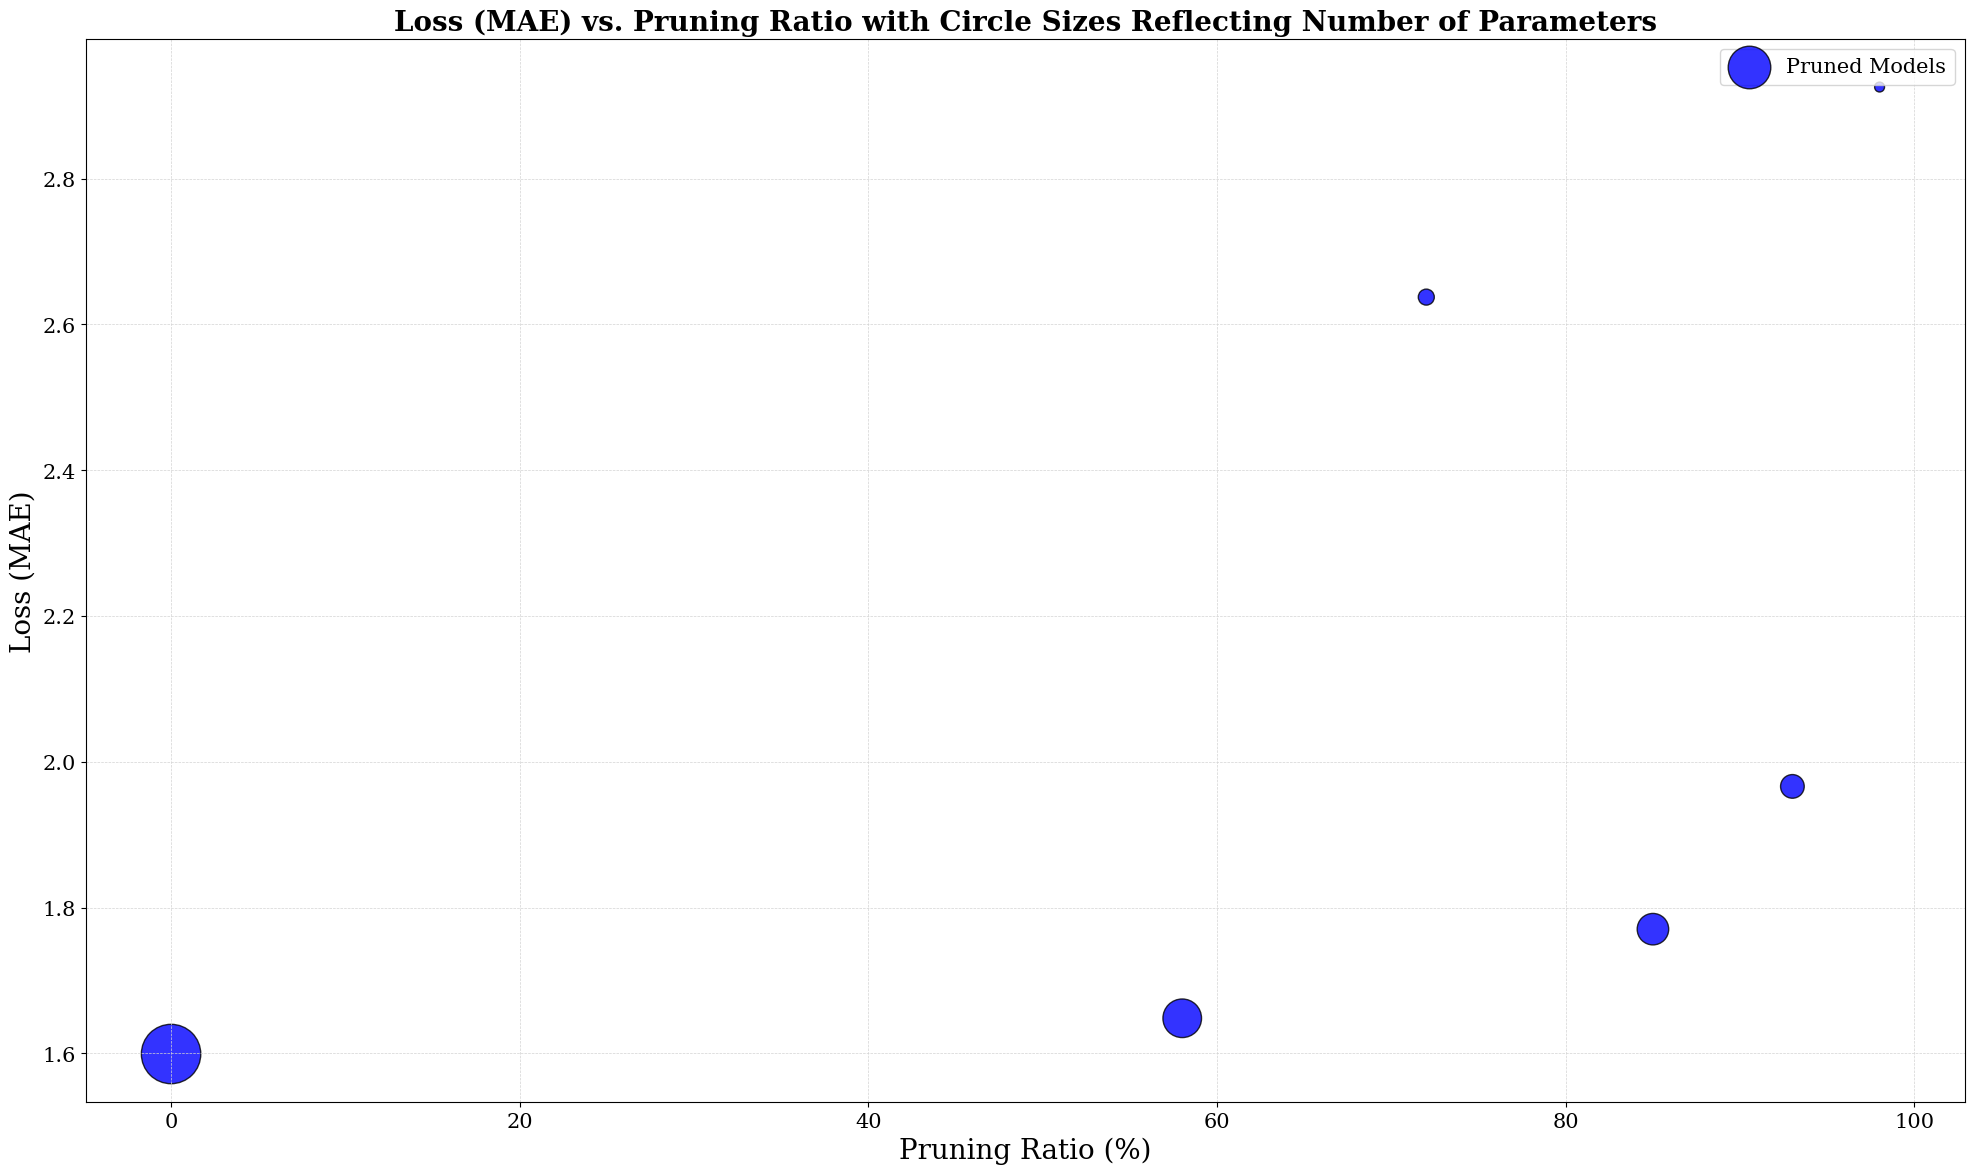

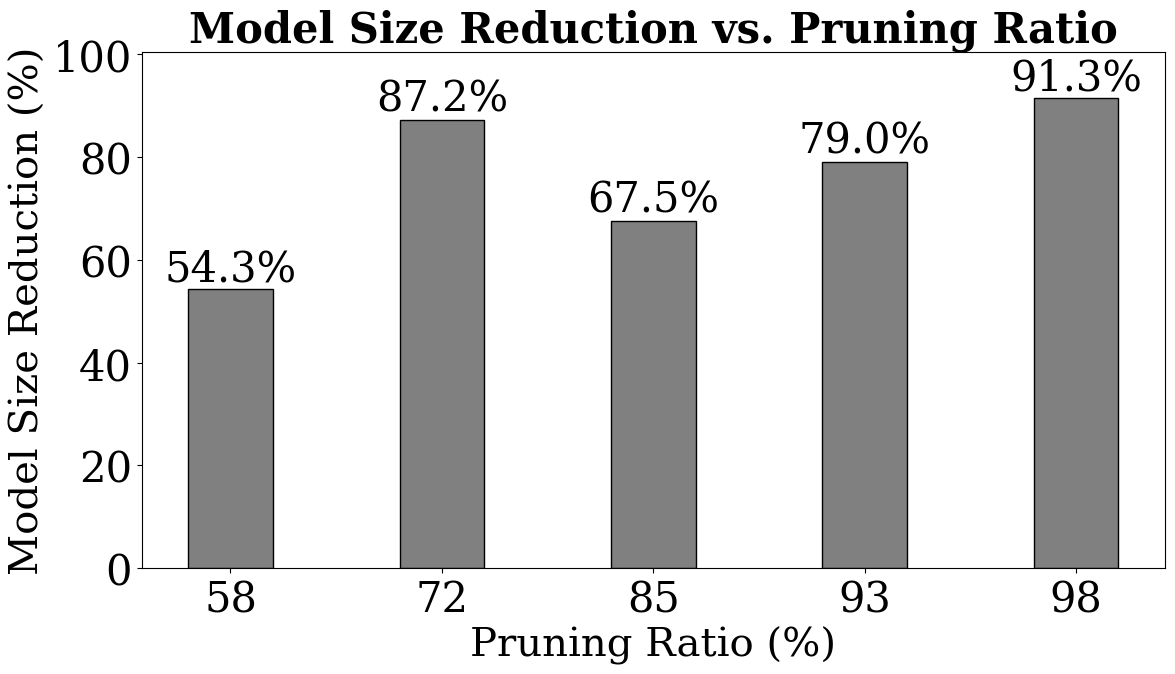

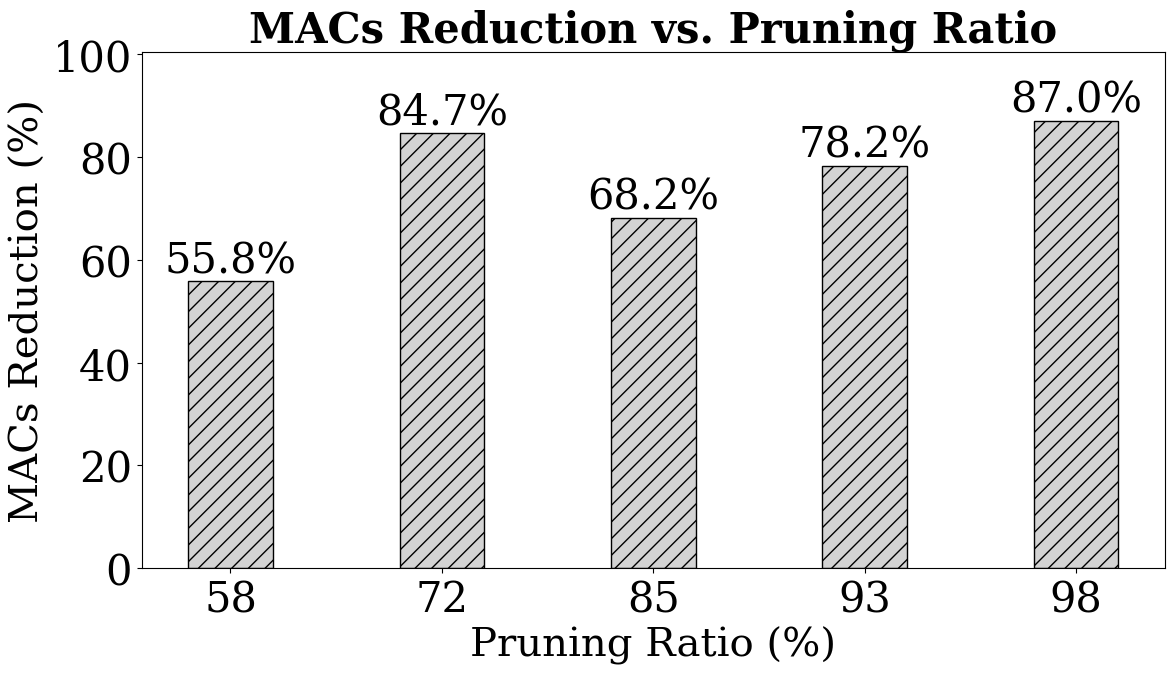

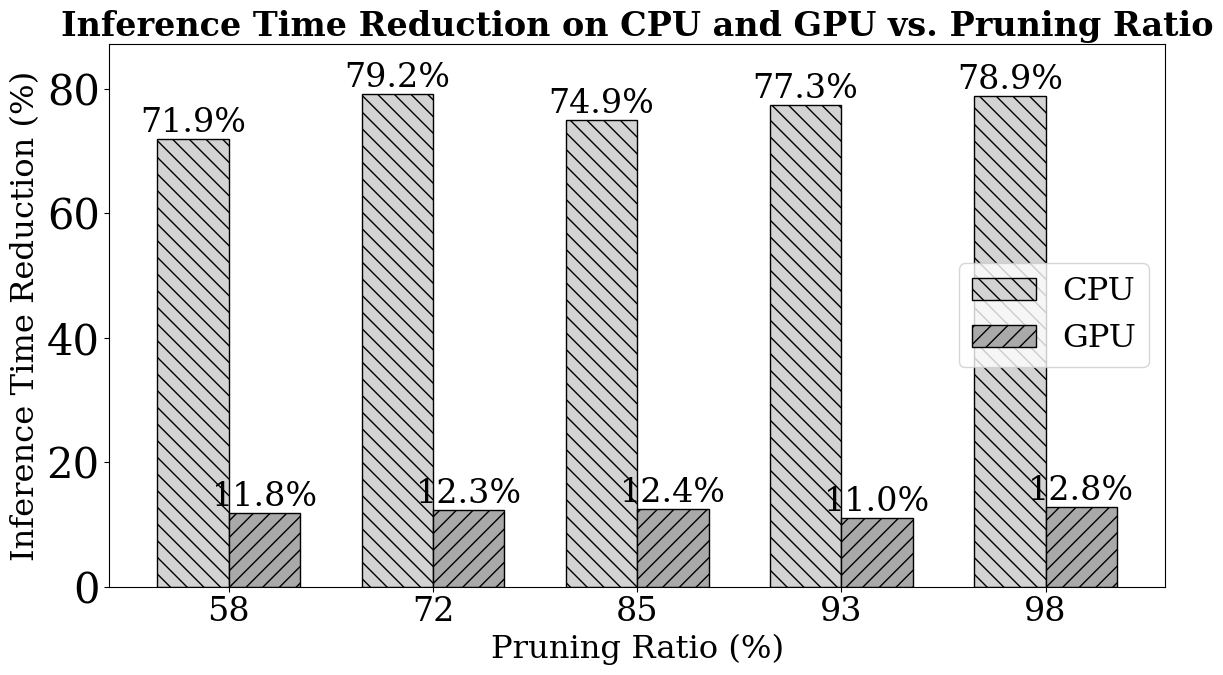

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace with actual values)
pruning_ratios = [98, 72, 93, 85, 58, 0]  # Pruning ratios
losses = loss_list   # Loss (MAE) values for each model
num_parameters = num_params   # Number of parameters for each model
model_sizes = model_sizes_list  # Add original model size in MB
macs_count = macs_list   # Add original model MACs

if your_hardware:
    inference_time_gpu = inference_time_gpu_list #[6.787206225585938, 7.8285044677734374, 6.919866894531249, 6.989533398437499, 9.500997460937501, 16.17931850585937]
    inference_time_cpu = inference_time_cpu_list #[0.0393, 0.0487, 0.0403, 0.0408, 0.0498, 0.1849]

else:
    inference_time_gpu = [6.787206225585938, 7.8285044677734374, 6.919866894531249, 6.989533398437499, 9.500997460937501, 16.17931850585937]
    inference_time_cpu = [0.0393, 0.0487, 0.0403, 0.0408, 0.0498, 0.1849]

# Scale the sizes of the circles based on the number of parameters for better visibility
size_scale = 300
sizes = [p / size_scale for p in num_parameters]

# Set general font settings for a formal style
plt.rcParams.update({'font.size': 15, 'font.family': 'serif'})

# Plot Loss vs. Pruning Ratio with circle size representing number of parameters
plt.figure(figsize=(20, 12))
plt.scatter(pruning_ratios, losses, s=sizes, c='blue', alpha=0.8, edgecolors="black", label="Pruned Models")
plt.xlabel("Pruning Ratio (%)", fontsize=20)
plt.ylabel("Loss (MAE)", fontsize=20)
plt.title("Loss (MAE) vs. Pruning Ratio with Circle Sizes Reflecting Number of Parameters", fontsize=20, weight='bold')

# # Add annotations for number of parameters for each point
# for i, txt in enumerate(num_parameters):
#     formatted_txt = f"{txt / 1e3:.2f}K"  # Format as thousands (K)
#     plt.annotate(formatted_txt, (pruning_ratios[i], losses[i]), 
#                  textcoords="offset points", xytext=(0,-12), ha='center', fontsize=20)

# Legend with smaller font size
plt.legend()

# Subtle grid lines for a clean look
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Original model values for comparison (last entry in each list)
original_model_size = model_sizes[-1]
original_macs = macs_count[-1]
original_inference_time_gpu = inference_time_gpu[-1]
original_inference_time_cpu = inference_time_cpu[-1]

# Calculate percentage reductions
model_size_reduction = [(1 - (size / original_model_size)) * 100 for size in model_sizes]
macs_reduction = [(1 - (macs / original_macs)) * 100 for macs in macs_count]
inference_time_reduction_gpu = [(1 - (time / original_inference_time_gpu)) * 100 for time in inference_time_gpu]
inference_time_reduction_cpu = [(1 - (time / original_inference_time_cpu)) * 100 for time in inference_time_cpu]

# Sort data by pruning ratio
sorted_data = sorted(zip(pruning_ratios, model_size_reduction, macs_reduction, inference_time_reduction_gpu, inference_time_reduction_cpu), key=lambda x: x[0])
sorted_pruning_ratios, sorted_model_size_reduction, sorted_macs_reduction, sorted_inference_time_reduction_gpu, sorted_inference_time_reduction_cpu = zip(*sorted_data[1:])

# Set up x positions for bars
x = np.arange(len(sorted_pruning_ratios))
bar_width = 0.4  # Narrower bars for better spacing

# Common settings for font sizes
label_fontsize = 29
title_fontsize = 30
tick_fontsize = 30
value_fontsize = 30


# Plot Model Size Reduction
fig, ax1 = plt.subplots(figsize=(12, 7))
# Adjust y-axis limit to create padding at the top
ax1.set_ylim(0, max(sorted_model_size_reduction) * 1.1)

bars1 = ax1.bar(x, sorted_model_size_reduction, width=bar_width, color='gray', edgecolor='black')
ax1.set_xlabel("Pruning Ratio (%)", fontsize=label_fontsize)
ax1.set_ylabel("Model Size Reduction (%)", fontsize=label_fontsize)
ax1.set_title("Model Size Reduction vs. Pruning Ratio", fontsize=title_fontsize, weight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([str(ratio) for ratio in sorted_pruning_ratios], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelsize=tick_fontsize)

# Add value labels on top of each bar
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.1f}%", ha='center', va='bottom', fontsize=value_fontsize)

plt.tight_layout()
plt.show()

# Plot MACs Reduction
fig, ax2 = plt.subplots(figsize=(12, 7))
ax2.set_ylim(0, max(sorted_model_size_reduction) * 1.1)

bars2 = ax2.bar(x, sorted_macs_reduction, width=bar_width, color='lightgray', edgecolor='black', hatch='//')
ax2.set_xlabel("Pruning Ratio (%)", fontsize=label_fontsize)
ax2.set_ylabel("MACs Reduction (%)", fontsize=label_fontsize)
ax2.set_title("MACs Reduction vs. Pruning Ratio", fontsize=title_fontsize, weight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([str(ratio) for ratio in sorted_pruning_ratios], fontsize=tick_fontsize)
ax2.tick_params(axis='y', labelsize=tick_fontsize)

# Add value labels on top of each bar
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.1f}%", ha='center', va='bottom', fontsize=value_fontsize)

plt.tight_layout()
plt.show()

# # Plot Inference Time Reduction
# fig, ax3 = plt.subplots(figsize=(12, 7))
# ax3.set_ylim(0, max(sorted_model_size_reduction) * 1.1)

# bars3 = ax3.bar(x, sorted_inference_time_reduction_cpu, width=bar_width, color='darkgray', edgecolor='black', hatch='\\\\')
# ax3.set_xlabel("Pruning Ratio (%)", fontsize=label_fontsize)
# ax3.set_ylabel("Inference Time Reduction (%)", fontsize=label_fontsize)
# ax3.set_title("Inference Time Reduction vs. Pruning Ratio", fontsize=title_fontsize, weight='bold')
# ax3.set_xticks(x)
# ax3.set_xticklabels([str(ratio) for ratio in sorted_pruning_ratios], fontsize=tick_fontsize)
# ax3.tick_params(axis='y', labelsize=tick_fontsize)

# # Add value labels on top of each bar
# for bar in bars3:
#     yval = bar.get_height()
#     ax3.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.1f}%", ha='center', va='bottom', fontsize=value_fontsize)

# plt.tight_layout()
# plt.show()

# # Plot Inference Time Reduction on CPU
# fig, ax3 = plt.subplots(figsize=(12, 7))
# ax3.set_ylim(0, max(sorted_model_size_reduction) * 1.1)

# bars3 = ax3.bar(x, sorted_inference_time_reduction_gpu, width=bar_width, color='darkgray', edgecolor='black', hatch='\\\\')
# ax3.set_xlabel("Pruning Ratio (%)", fontsize=label_fontsize)
# ax3.set_ylabel("Inference Time Reduction (%)", fontsize=label_fontsize)
# ax3.set_title("Inference Time Reduction vs. Pruning Ratio", fontsize=title_fontsize, weight='bold')
# ax3.set_xticks(x)
# ax3.set_xticklabels([str(ratio) for ratio in sorted_pruning_ratios], fontsize=tick_fontsize)
# ax3.tick_params(axis='y', labelsize=tick_fontsize)

# # Add value labels on top of each bar
# for bar in bars3:
#     yval = bar.get_height()
#     ax3.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.1f}%", ha='center', va='bottom', fontsize=value_fontsize)

# plt.tight_layout()
# plt.show()

# Combine both CPU and GPU inference time reduction into one chart
fig, ax = plt.subplots(figsize=(12, 7))

# Set width of bars and positions for each group
bar_width = 0.35  # Adjust width to fit both bars in one group
x = range(len(sorted_pruning_ratios))  # Indices for each pruning ratio
x_cpu = [pos - bar_width / 2 for pos in x]  # Position CPU bars on the left
x_gpu = [pos + bar_width / 2 for pos in x]  # Position GPU bars on the right

# Plot bars for CPU and GPU inference time reduction
bars_cpu = ax.bar(x_cpu, sorted_inference_time_reduction_cpu, width=bar_width, color='lightgray', edgecolor='black', label="CPU", hatch='\\\\')
bars_gpu = ax.bar(x_gpu, sorted_inference_time_reduction_gpu, width=bar_width, color='darkgray', edgecolor='black', label="GPU", hatch='//')

# Labels and titles
ax.set_xlabel("Pruning Ratio (%)", fontsize=label_fontsize*0.8)
ax.set_ylabel("Inference Time Reduction (%)", fontsize=label_fontsize*0.8)
ax.set_title("Inference Time Reduction on CPU and GPU vs. Pruning Ratio", fontsize=title_fontsize*0.8, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels([str(ratio) for ratio in sorted_pruning_ratios], fontsize=tick_fontsize*0.8)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_ylim(0, max(max(sorted_inference_time_reduction_cpu), max(sorted_inference_time_reduction_gpu)) * 1.1)

# Add value labels on top of each bar
for bars, label in zip([bars_cpu, bars_gpu], ["CPU", "GPU"]):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.1f}%", ha='center', va='bottom', fontsize=value_fontsize*0.8)

# Add legend
ax.legend(fontsize=label_fontsize*0.8)

plt.tight_layout()
plt.show()


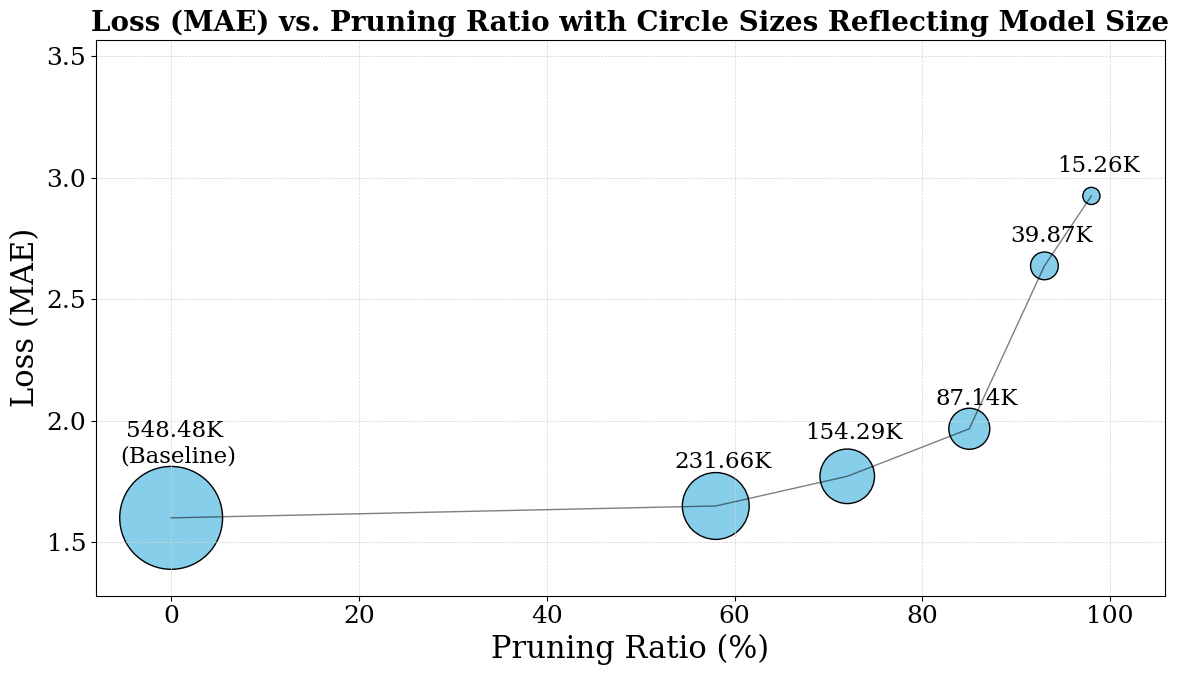

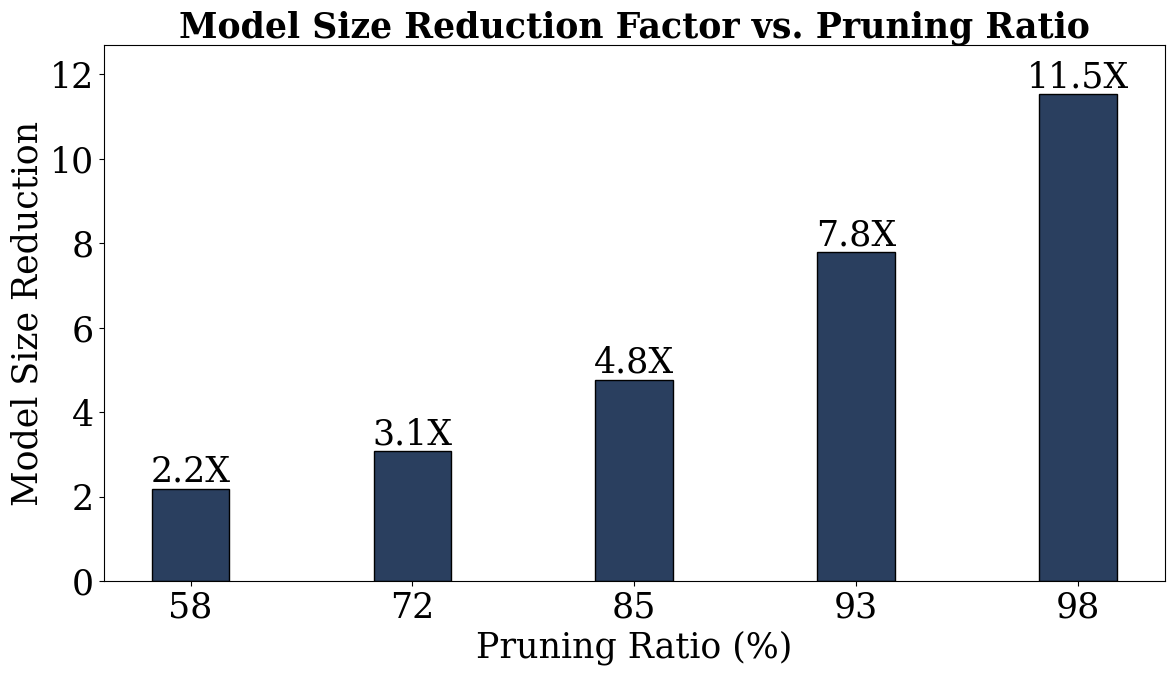

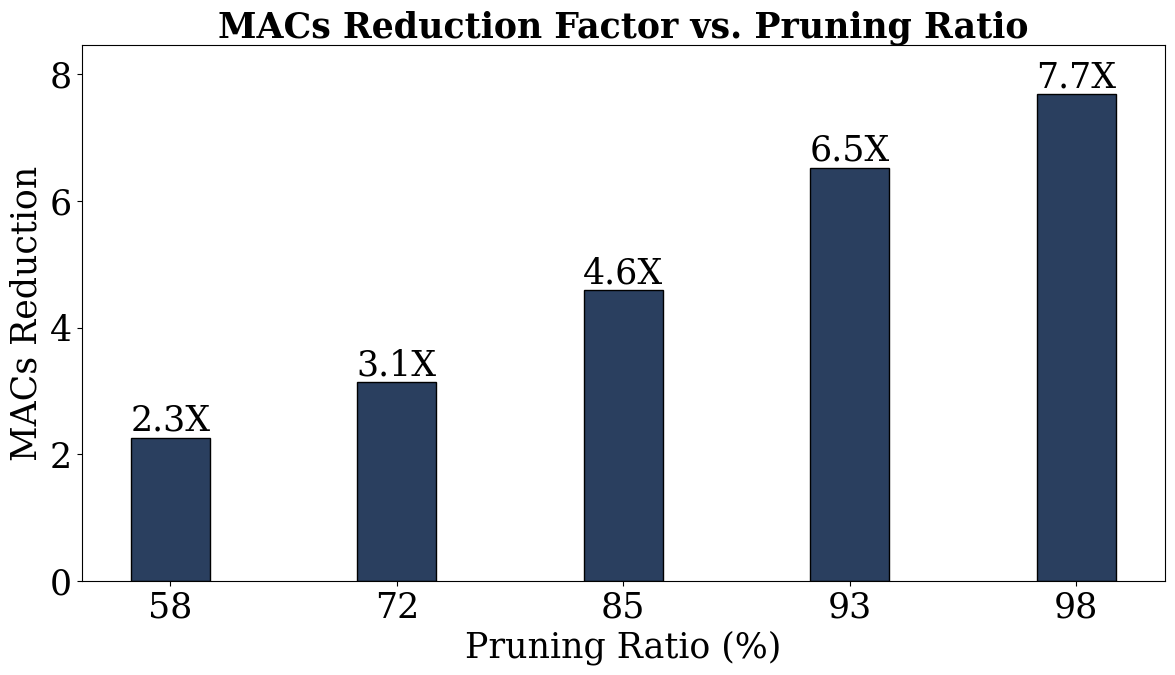

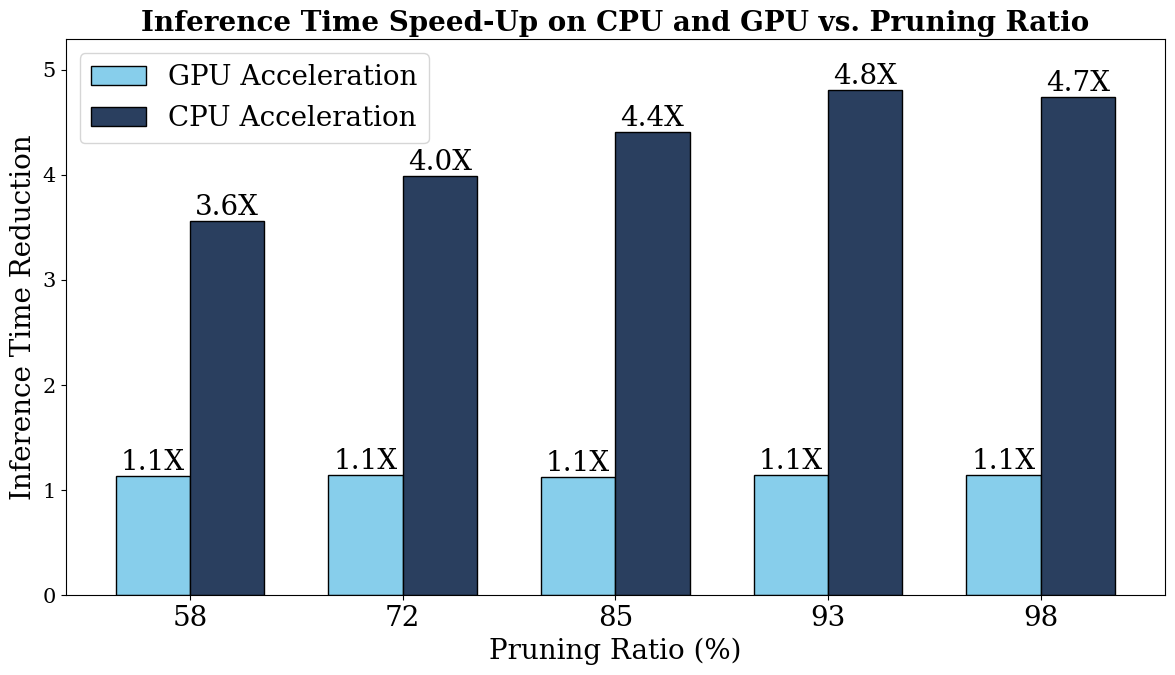

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

pruning_ratios = [98, 93, 85, 72, 58, 0]  # Pruning ratios
losses = loss_list   # Loss (MAE) values for each model
num_parameters = num_params   # Number of parameters for each model
model_sizes = model_sizes_list   # Add original model size in MB
macs_count = macs_list   # Add original model MACs

if your_hardware:
    inference_time_gpu = inference_time_gpu_list #[6.787206225585938, 7.8285044677734374, 6.919866894531249, 6.989533398437499, 9.500997460937501, 16.17931850585937]
    inference_time_cpu = inference_time_cpu_list #[0.0393, 0.0487, 0.0403, 0.0408, 0.0498, 0.1849]

else:
    inference_time_gpu = [6.787206225585938, 7.8285044677734374, 6.919866894531249, 6.989533398437499, 9.500997460937501, 16.17931850585937]
    inference_time_cpu = [0.0393, 0.0487, 0.0403, 0.0408, 0.0498, 0.1849]

# Sort all data by pruning ratio
combined_data = sorted(zip(pruning_ratios, losses, num_parameters, model_sizes, macs_count, inference_time_gpu, inference_time_cpu), key=lambda x: x[0])
pruning_ratios, losses, num_parameters, model_sizes, macs_count, inference_time_gpu, inference_time_cpu = map(list, zip(*combined_data))

# Define colors
# dark_blue = '#2A3F5F'     # Formal dark blue for primary bars
# steel_blue = '#4F6D8C'    # Muted steel blue for MACs Reduction
# medium_gray = '#A9A9A9'   # Medium gray for CPU bars
# dark_gray = '#696969'     # Darker gray for GPU bars
medium_blue = '#4F6D8C'   # Medium blue for CPU bars
dark_navy_blue = '#87CEEB'     # Darker blue for GPU bars

# Define colors
dark_blue = '#2A3F5F'     # For Model Size Reduction
steel_blue = '#87CEEB'    # For Parameter Reduction

# Circle sizes for scatter plot
size_scale = 100
sizes = [p / size_scale for p in num_parameters]

# Plot settings
plt.rcParams.update({'font.size': 15, 'font.family': 'serif'})

# Scatter plot: Loss vs. Pruning Ratio
plt.figure(figsize=(12, 7))
plt.scatter(pruning_ratios, losses, s=sizes, c=steel_blue, alpha=1, edgecolors="black", label="Pruned Models")

# Add line connecting the circles
plt.plot(pruning_ratios, losses, linestyle='-', color='black', linewidth=1, alpha=0.5)  # Fine line connecting points

# Label and title settings
plt.xlabel("Pruning Ratio (%)", fontsize=22)
plt.ylabel("Loss (MAE)", fontsize=22)
plt.title("Loss (MAE) vs. Pruning Ratio with Circle Sizes Reflecting Model Size", fontsize=20, weight='bold')

# Set font size for x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim(pruning_ratios[0]-8, pruning_ratios[-1] * 1.08)
plt.ylim(losses[0] * 0.8, losses[-1] * 1.22)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

# Add annotations for number of parameters for each point with relative placement
for i, txt in enumerate(num_parameters):
    formatted_txt = f"{txt / 1e3:.2f}K"  # Format as thousands (K)
    
    # Adjust the offset dynamically based on specific conditions
    if i == 0:
        offset_x = 5  
        offset_y = 40
        formatted_txt = f"{txt / 1e3:.2f}K \n(Baseline)"
    elif i in {len(num_parameters) - 1, len(num_parameters) - 2, len(num_parameters) - 3}:
        offset_x = 5 
        offset_y = 17
    else:
        offset_x = 5 
        offset_y = 27

    plt.annotate(formatted_txt, (pruning_ratios[i], losses[i]), 
                 textcoords="offset points", xytext=(offset_x, offset_y), ha='center', fontsize=16.5)

plt.tight_layout()
plt.show()


# Original model values for comparisons
original_model_size = model_sizes[0]
original_macs = macs_count[0]
original_inference_time_gpu = inference_time_gpu[0]
original_inference_time_cpu = inference_time_cpu[0]

# Calculate reductions and factors
model_size_factor = [original_model_size / size for size in model_sizes]
macs_factor = [original_macs / macs for macs in macs_count]
inference_time_factor_gpu = [original_inference_time_gpu / time for time in inference_time_gpu]
inference_time_factor_cpu = [original_inference_time_cpu / time for time in inference_time_cpu]

pruning_ratios = pruning_ratios[1:]

import numpy as np
import matplotlib.pyplot as plt


# X positions for bar plots
x = np.arange(len(pruning_ratios))
bar_width = 0.35
label_fontsize = 25
title_fontsize = 25
tick_fontsize = 25
value_fontsize = 25

# # Plot Model Size Reduction as multiplicative factor
# fig, ax1 = plt.subplots(figsize=(12, 7))
# ax1.set_ylim(0, max(model_size_factor) * 1.1)
# bars1 = ax1.bar(x, model_size_factor[1:], width=bar_width, color=dark_blue, edgecolor='black')
# ax1.set_xlabel("Pruning Ratio (%)", fontsize=label_fontsize)
# ax1.set_ylabel("Model Size Reduction", fontsize=label_fontsize)
# ax1.set_title("Model Size Reduction Factor vs. Pruning Ratio", fontsize=title_fontsize, weight='bold')
# ax1.set_xticks(x)
# ax1.set_xticklabels([str(ratio) for ratio in pruning_ratios], fontsize=tick_fontsize)
# ax1.tick_params(axis='y', labelsize=tick_fontsize)
# for bar in bars1:
#     yval = bar.get_height()
#     ax1.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.1f}X", ha='center', va='bottom', fontsize=value_fontsize)
# plt.tight_layout()
# plt.show()

# Plot MACs Reduction as speed-up factor
fig, ax2 = plt.subplots(figsize=(12, 7))
ax2.set_ylim(0, max(macs_factor) * 1.1)
bars2 = ax2.bar(x, macs_factor[1:], width=bar_width, color=dark_blue, edgecolor='black')
ax2.set_xlabel("Pruning Ratio (%)", fontsize=label_fontsize)
ax2.set_ylabel("MACs Reduction", fontsize=label_fontsize)
ax2.set_title("MACs Reduction Factor vs. Pruning Ratio", fontsize=title_fontsize, weight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([str(ratio) for ratio in pruning_ratios], fontsize=tick_fontsize)
ax2.tick_params(axis='y', labelsize=tick_fontsize)
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.1f}X", ha='center', va='bottom', fontsize=value_fontsize)
plt.tight_layout()
plt.show()

# Plot Inference Time Speed-Up on CPU and GPU
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_ylim(0, max(inference_time_factor_cpu) * 1.1)

x_gpu = [pos - bar_width / 2 for pos in x]  
x_cpu = [pos + bar_width / 2 for pos in x]  
# Plot bars
bars_gpu = ax.bar(x_gpu, inference_time_factor_gpu[1:], width=bar_width, color=dark_navy_blue, edgecolor='black', label="GPU Acceleration")
bars_cpu = ax.bar(x_cpu, inference_time_factor_cpu[1:], width=bar_width, color=dark_blue, edgecolor='black', label="CPU Acceleration")

# Labels and title
ax.set_xlabel("Pruning Ratio (%)", fontsize=label_fontsize * 0.8)
ax.set_ylabel("Inference Time Reduction", fontsize=label_fontsize * 0.8)
ax.set_title("Inference Time Speed-Up on CPU and GPU vs. Pruning Ratio", fontsize=title_fontsize * 0.8, weight='bold')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels([str(ratio) for ratio in pruning_ratios], fontsize=tick_fontsize * 0.8)

# Add labels to the bars
for bars, label in zip([bars_gpu, bars_cpu], ["GPU", "CPU"]):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.1f}X", ha='center', va='bottom', fontsize=value_fontsize * 0.8)

# Add legend
ax.legend(fontsize=label_fontsize * 0.8)
plt.tight_layout()
plt.show()


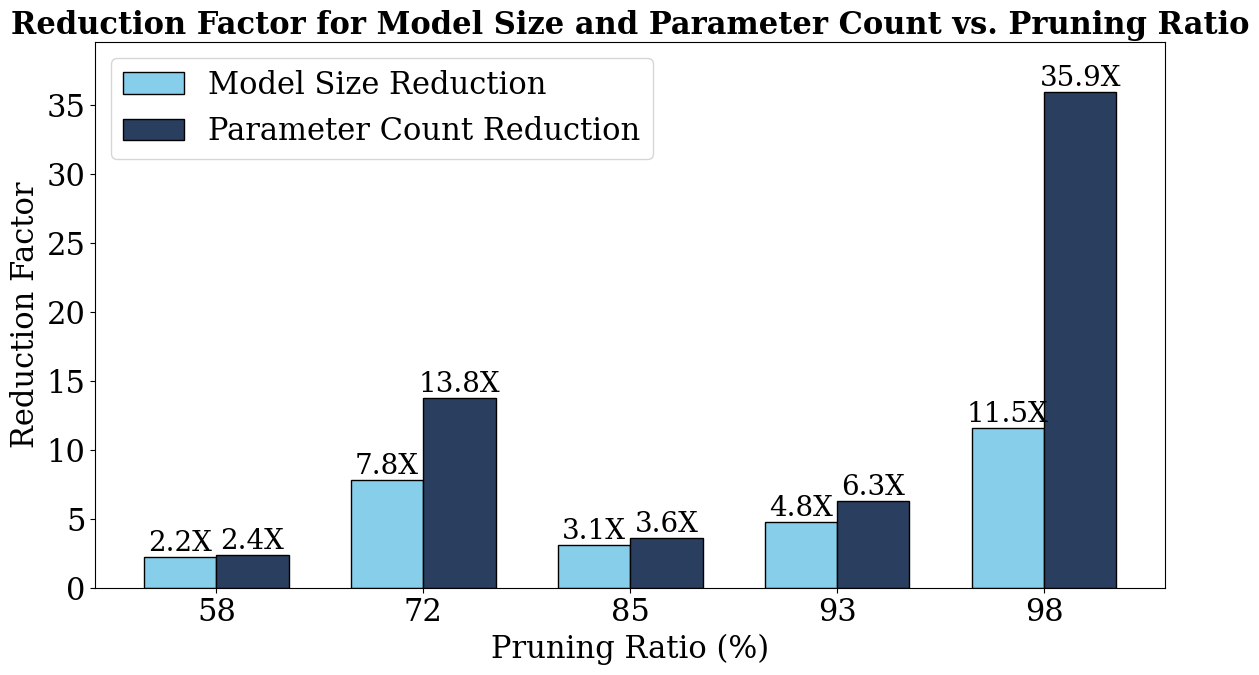

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
pruning_ratios = [98, 72, 93, 85, 58, 0]  # Pruning ratios
num_parameters = num_params   # Number of parameters for each model
model_sizes = model_sizes_list  # Add original model size in MB

# Sort all data by pruning ratio
combined_data = sorted(zip(pruning_ratios, model_sizes, num_parameters), key=lambda x: x[0])
pruning_ratios, model_sizes, num_parameters = map(list, zip(*combined_data))

# Original values for comparison
original_model_size = model_sizes[0]
original_num_parameters = num_parameters[0]

# Calculate reduction factors
model_size_factor = [original_model_size / size for size in model_sizes]
parameter_reduction_factor = [original_num_parameters / param for param in num_parameters]

# Define colors
dark_blue = '#2A3F5F'     # For Model Size Reduction
steel_blue = '#87CEEB'    # For Parameter Reduction

# medium_blue = '#5B6C8C'   # Medium blue for CPU bars
# dark_navy_blue = '#6A89CC'     # Darker blue for GPU bars

# X positions for bar plots
x = np.arange(len(pruning_ratios[1:]))
bar_width = 0.35

# Plot Model Size and Parameter Reduction as multiplicative factors
fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.set_ylim(0, max(max(model_size_factor), max(parameter_reduction_factor)) * 1.1)

# Model size reduction bars
bars1 = ax1.bar(x - bar_width / 2, model_size_factor[1:], width=bar_width, color=steel_blue, edgecolor='black', label="Model Size Reduction")
# Parameter count reduction bars
bars2 = ax1.bar(x + bar_width / 2, parameter_reduction_factor[1:], width=bar_width, color=dark_blue, edgecolor='black', label="Parameter Count Reduction")

# Labels and Title
label_fontsize = 22
title_fontsize = 22
tick_fontsize = 22
value_fontsize = 20
ax1.set_xlabel("Pruning Ratio (%)", fontsize=label_fontsize)
ax1.set_ylabel("Reduction Factor", fontsize=label_fontsize)
ax1.set_title("Reduction Factor for Model Size and Parameter Count vs. Pruning Ratio", fontsize=title_fontsize, weight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([str(ratio) for ratio in pruning_ratios[1:]], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelsize=tick_fontsize)

# Adding text labels on the bars
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.1f}X", ha='center', va='bottom', fontsize=value_fontsize)

for bar in bars2:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.1f}X", ha='center', va='bottom', fontsize=value_fontsize)

# Legend
ax1.legend(fontsize=tick_fontsize)

plt.tight_layout()
plt.show()


In [84]:
# Define paths and parameters
models_folder = '/home/mohammad.hallaq/workarea/MobileNet_compression/different_methods_comparison'
general_device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
test_loader = test_loader
loss_list = []
model_sizes_list = []
num_params = []
macs_list = []

# Loop over each model in the folder
for model_file in Path(models_folder).glob('*.pth'):
    print(f"Processing {model_file.name}")
    
    # Load the pruned model
    pruned_model = torch.load(model_file)
    pruned_model.to(general_device)
    
    # Initialize classifier and test
    rf_classifier_pruned = RFClassifier(pruned_model)
    trainer = L.Trainer(
        max_epochs=1,
        accelerator='gpu',
        devices=[3],
        benchmark=True,
        precision='32-true',
    )
    
    # Capture test results to get loss
    test_results = trainer.test(rf_classifier_pruned, test_loader)
    test_loss = test_results[0]['test_loss']  # Adjust key name based on your LightningModule test output
    loss_list.append(test_loss)
    
    # Number of parameters and MACs
    torch.cuda.empty_cache()
    pruned_model.to(general_device)
    example_inputs = torch.randn(1, 8, 4096).to(general_device)
    macs, nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
    num_params.append(nparams)
    macs_list.append(macs)
    
    # Calculate model size in MB
    model_size = os.path.getsize(model_file) / (1024 ** 2)
    model_sizes_list.append(model_size)
    
    # Print results for each model
    print(f"Model: {model_file.name}, Loss: {test_loss}, MACs: {macs/1e9:.2f} G, #Params: {nparams/1e3:.2f} K, Size: {model_size:.2f} MB")

# Final summary (optional)
print("\nSummary:")
for idx, model_file in enumerate(Path(models_folder).glob('*.pth')):
    print(f"{model_file.name}: Loss = {loss_list[idx]}, #Params = {num_params[idx]/1e3:.2f}K, MACs = {macs_list[idx]/1e9:.2f}G, Size = {model_sizes_list[idx]:.2f} MB")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Processing 15k_pruned_model.pth


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.925483226776123     │
└───────────────────────────┴───────────────────────────┘

Model: 15k_pruned_model.pth, Loss: 2.925483226776123, MACs: 0.00 G, #Params: 15.26 K, Size: 0.20 MB
Processing 15.1k_globaly_pruned_model.pth


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    12.992300033569336     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Model: 15.1k_globaly_pruned_model.pth, Loss: 12.992300033569336, MACs: 0.00 G, #Params: 15.14 K, Size: 0.19 MB
Processing 14.5k_pruned_model.pth


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     7.567073822021484     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Model: 14.5k_pruned_model.pth, Loss: 7.567073822021484, MACs: 0.00 G, #Params: 14.49 K, Size: 0.19 MB
Processing best_trained_model.pth


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.5988198518753052     │
└───────────────────────────┴───────────────────────────┘

Model: best_trained_model.pth, Loss: 1.5988198518753052, MACs: 0.02 G, #Params: 548.48 K, Size: 2.25 MB

Summary:
15k_pruned_model.pth: Loss = 2.925483226776123, #Params = 15.26K, MACs = 0.00G, Size = 0.20 MB
15.1k_globaly_pruned_model.pth: Loss = 12.992300033569336, #Params = 15.14K, MACs = 0.00G, Size = 0.19 MB
14.5k_pruned_model.pth: Loss = 7.567073822021484, #Params = 14.49K, MACs = 0.00G, Size = 0.19 MB
best_trained_model.pth: Loss = 1.5988198518753052, #Params = 548.48K, MACs = 0.02G, Size = 2.25 MB


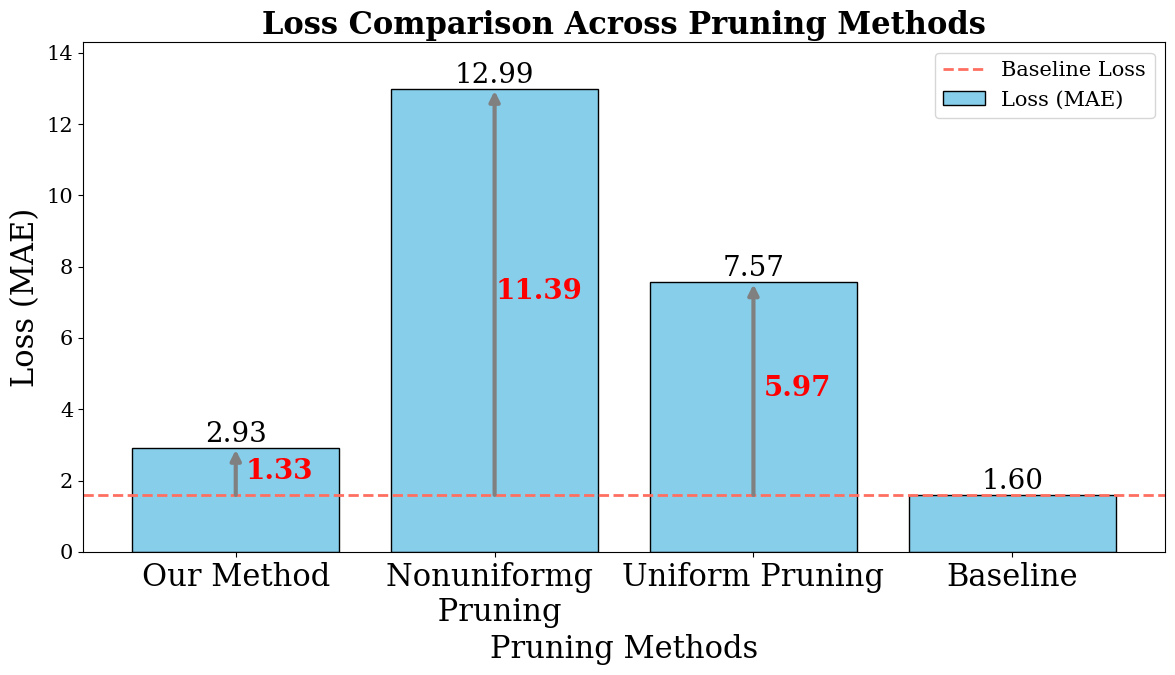

In [85]:
pruning_methods = ['Our Method', 'Nonuniformg \n Pruning', 'Uniform Pruning', 'Baseline']  # Pruning ratios
losses = loss_list   # Loss (MAE) values for each model
num_parameters = num_params  # Number of parameters for each model
model_sizes = model_sizes_list  # Add original model size in MB
macs_count = macs_list  # Add original model MACs

# Labels and Title
label_fontsize = 22
title_fontsize = 22
tick_fontsize = 22
value_fontsize = 20

# X-axis positions for each method
x = np.arange(len(pruning_methods))

# Define figure and axes
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_ylim(0, max(max(losses), max(losses)) * 1.1)

# Plot loss values as a bar plot
ax.bar(x, losses, color='#87CEEB', edgecolor='black', label='Loss (MAE)')

# Add baseline reference line for loss
baseline_loss = losses[-1]  # Assuming the last value is the baseline
ax.axhline(y=baseline_loss, color='#FF6F61', linestyle='--', linewidth=2, label="Baseline Loss")

# Customize axis labels and title
ax.set_xlabel("Pruning Methods", fontsize=label_fontsize)
ax.set_ylabel("Loss (MAE)", fontsize=label_fontsize)
ax.set_title("Loss Comparison Across Pruning Methods", fontsize=title_fontsize, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pruning_methods, fontsize=tick_fontsize)
ax.legend()

# Annotate each bar with its loss value and add arrows/lines
for i, loss in enumerate(losses):
    ax.text(i, loss, f"{loss:.2f}", ha='center', va='bottom', fontsize=value_fontsize)
    
    # Only draw an arrow if it's not the baseline
    if i < len(losses) - 1:
        # Arrow parameters to show difference from baseline
        arrow_y = abs(loss + baseline_loss)  # Start from lower of the two
        height_difference = abs(loss - baseline_loss)
        
        # Draw the arrow or line indicating the difference
        ax.annotate(
            '', xy=(i, baseline_loss), xytext=(i, loss-0.06),
            arrowprops=dict(
                arrowstyle='<|-',  # More prominent arrow style
                color='gray' if loss > baseline_loss else 'green',
                linestyle='-',
                linewidth=3,  # Increase line thickness
                shrinkA=0, shrinkB=0,  # Reduce shrinking to keep arrowhead close to points
                mutation_scale=15  # Controls the size of the arrowhead
            ),
        )
        
        # Add the difference as text next to the arrow
        ax.text(i + 0.17, arrow_y/2 , f"{height_difference:.2f}", 
                ha='center', va='center', color='red' if loss > baseline_loss else 'green', fontsize=value_fontsize, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Define paths and parameters
models_folder = '/home/mohammad.hallaq/workarea/MobileNet_compression/inference_cmparison'
general_device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
test_loader = test_loader
loss_list = []
model_sizes_list = []
num_params = []
macs_list = []

# Loop over each model in the folder
for model_file in Path(models_folder).glob('*.pth'):
    print(f"Processing {model_file.name}")
    
    # Load the pruned model
    pruned_model = torch.load(model_file)
    pruned_model.to(general_device)
    
    # Initialize classifier and test
    rf_classifier_pruned = RFClassifier(pruned_model)
    trainer = L.Trainer(
        max_epochs=1,
        accelerator='gpu',
        benchmark=True,
        precision='32-true',
    )
    
    # Capture test results to get loss
    test_results = trainer.test(rf_classifier_pruned, test_loader)
    test_loss = test_results[0]['test_loss']  # Adjust key name based on your LightningModule test output
    loss_list.append(test_loss)
    
    # Number of parameters and MACs
    torch.cuda.empty_cache()
    pruned_model.to(general_device)
    example_inputs = torch.randn(1, 8, 4096).to(general_device)
    macs, nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
    num_params.append(nparams)
    macs_list.append(macs)
    
    # Calculate model size in MB
    model_size = os.path.getsize(model_file) / (1024 ** 2)
    model_sizes_list.append(model_size)
    
    # Print results for each model
    print(f"Model: {model_file.name}, Loss: {test_loss}, MACs: {macs/1e9:.2f} G, #Params: {nparams/1e3:.2f} K, Size: {model_size:.2f} MB")

# Final summary (optional)
print("\nSummary:")
for idx, model_file in enumerate(Path(models_folder).glob('*.pth')):
    print(f"{model_file.name}: Loss = {loss_list[idx]}, #Params = {num_params[idx]/1e3:.2f}K, MACs = {macs_list[idx]/1e9:.2f}G, Size = {model_sizes_list[idx]:.2f} MB")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Processing 97sparsity_pruned_model.pth


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    10.888278007507324     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Model: 97sparsity_pruned_model.pth, Loss: 10.888278007507324, MACs: 0.02 G, #Params: 548.48 K, Size: 2.25 MB
Processing 15k_pruned_model.pth


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.925483226776123     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Model: 15k_pruned_model.pth, Loss: 2.925483226776123, MACs: 0.00 G, #Params: 15.26 K, Size: 0.20 MB
Processing best_trained_model.pth


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.5988198518753052     │
└───────────────────────────┴───────────────────────────┘

Model: best_trained_model.pth, Loss: 1.5988198518753052, MACs: 0.02 G, #Params: 548.48 K, Size: 2.25 MB

Summary:
97sparsity_pruned_model.pth: Loss = 10.888278007507324, #Params = 548.48K, MACs = 0.02G, Size = 2.25 MB
15k_pruned_model.pth: Loss = 2.925483226776123, #Params = 15.26K, MACs = 0.00G, Size = 0.20 MB
best_trained_model.pth: Loss = 1.5988198518753052, #Params = 548.48K, MACs = 0.02G, Size = 2.25 MB


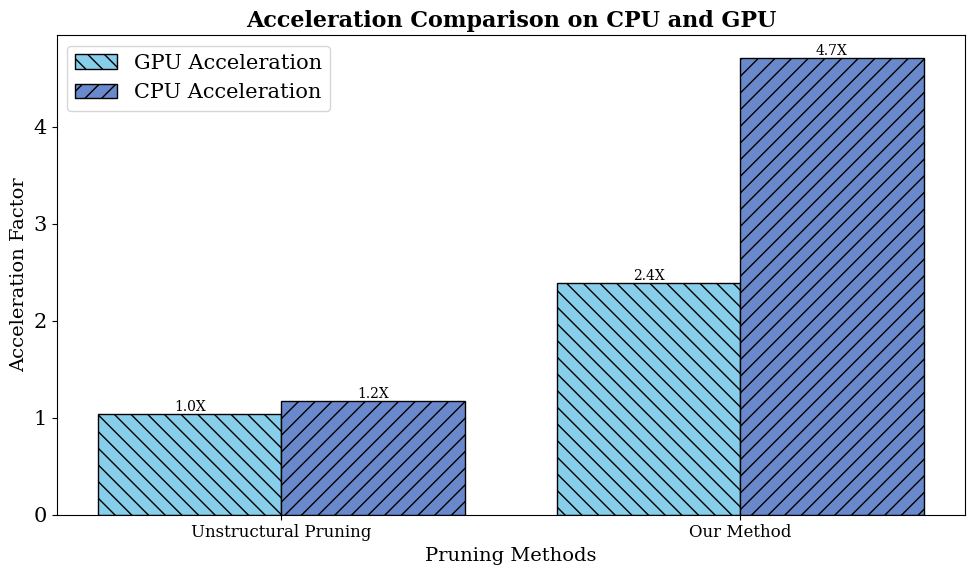

In [116]:
pruning_methods = ['Unstructural Pruning', 'Our Method', 'Baseline']  # Pruning ratios
losses = loss_list   # Loss (MAE) values for each model
num_parameters = num_params  # Number of parameters for each model
model_sizes = model_sizes_list  # Add original model size in MB
macs_count = macs_list  # Add original model MACs
inference_time_gpu = [15.565090820312502, 6.787206225585938, 16.17931850585937]
inference_time_cpu = [0.1574, 0.0393, 0.1849]


# Calculate acceleration factors relative to the baseline
baseline_gpu = inference_time_gpu[-1]
baseline_cpu = inference_time_cpu[-1]
acceleration_gpu = [baseline_gpu / time for time in inference_time_gpu[0:-1]]
acceleration_cpu = [baseline_cpu / time for time in inference_time_cpu[0:-1]]

# X-axis positions for each method
x = np.arange(len(pruning_methods[0:-1]))
bar_width = 0.4  # Width of each bar

# Define figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot grouped bars for CPU and GPU acceleration factors
bars_gpu = ax.bar(x - bar_width / 2, acceleration_gpu, width=bar_width, color='#87CEEB', edgecolor='black', label='GPU Acceleration', hatch='\\\\')
bars_cpu = ax.bar(x + bar_width / 2, acceleration_cpu, width=bar_width, color='#6A89CC', edgecolor='black', label='CPU Acceleration', hatch='//')

# Customize axis labels and title
ax.set_xlabel("Pruning Methods", fontsize=14)
ax.set_ylabel("Acceleration Factor", fontsize=14)
ax.set_title("Acceleration Comparison on CPU and GPU", fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pruning_methods[0:-1], fontsize=12)
ax.legend()

# Annotate each bar with acceleration factor
for i, (gpu_acc, cpu_acc) in enumerate(zip(acceleration_gpu, acceleration_cpu)):
    ax.text(i - bar_width / 2, gpu_acc, f"{gpu_acc:.1f}X", ha='center', va='bottom', fontsize=10, color='black')
    ax.text(i + bar_width / 2, cpu_acc, f"{cpu_acc:.1f}X", ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

## Evaluating The Pruned Model

In [34]:
pruned_model = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/chosen_pruned_models/pruned_model_17142params_16loss.pth')

In [20]:
# Free up cached memory
torch.cuda.empty_cache()
example_inputs = torch.randn(1, 8, 4096).to(general_device)
pruned_model.to(general_device)  
macs, nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
print(f"MACs: {macs/1e9} G, #Params: {nparams/1e3} K")

MACs: 0.00303319 G, #Params: 17.142 K


In [ ]:
# rf_classifier_original = RFClassifier(original_model)
rf_classifier_pruned = RFClassifier(pruned_model)

trainer = L.Trainer(
    max_epochs=1,
    accelerator='gpu',
    benchmark=True,
    precision='32-true',
)

# trainer.test(rf_classifier_original, test_loader)
trainer.test(rf_classifier_pruned, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     3.027646780014038     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.027646780014038}]

In [57]:
def plot_quiver(all_targets, all_outputs, quiver_path: str):
    """
    Creates and stores the quiver plot for given targets and predicted outputs
    :args all_targets:
    :args all_outputs:
    """
    predictions_per_target = defaultdict(list)
    errors_per_target = dict()

    for idx, target_angles_tuple in enumerate(all_targets):
        target_tuple = tuple(target_angles_tuple)
        predictions_per_target[target_tuple].append(all_outputs[idx])
    for target_tuple, list_of_predictions in predictions_per_target.items():
        # predictions_per_target[target_tuple] = np.mean(list_of_predictions, axis=0)
        errors_per_target[target_tuple] = np.subtract(target_tuple, np.mean(list_of_predictions, axis=0))

    unique_targets = list(errors_per_target.keys())
    unique_azimuth = [target[0] for target in unique_targets]
    unique_elevation = [target[1] for target in unique_targets]
    unique_erros = list(errors_per_target.values())
    errors_azimuth = [target[0] for target in unique_erros]
    errors_elevation = [target[1] for target in unique_erros]

    plt.figure(figsize=(10, 10))
    plt.scatter(unique_azimuth, unique_elevation, color='red', label='True Angles')
    plt.quiver(unique_azimuth, unique_elevation, errors_azimuth, errors_elevation,
                angles='xy', scale_units='xy', scale=1, color='blue', label='Predicted Angles')
    plt.xlim([-55, 55])
    plt.ylim([-55, 55])
    plt.xlabel('Azimuth')
    plt.ylabel('Elevation')
    plt.grid()
    plt.legend()
    plt.savefig(quiver_path)

Testing:   0%|          | 0/360 [00:00<?, ?batch/s]

Testing: 100%|██████████| 360/360 [00:13<00:00, 26.21batch/s, Val Loss=0.0924]


Test Set Loss = 0.00025679274240041387
Test Set Loss for pruned model = 0.0003791656117170389


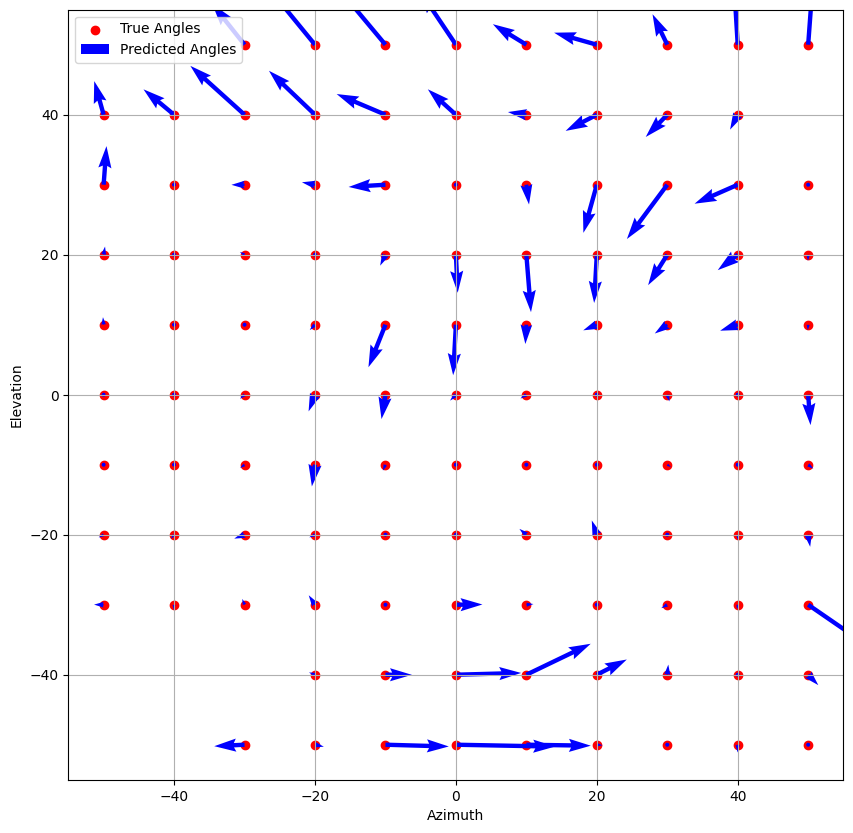

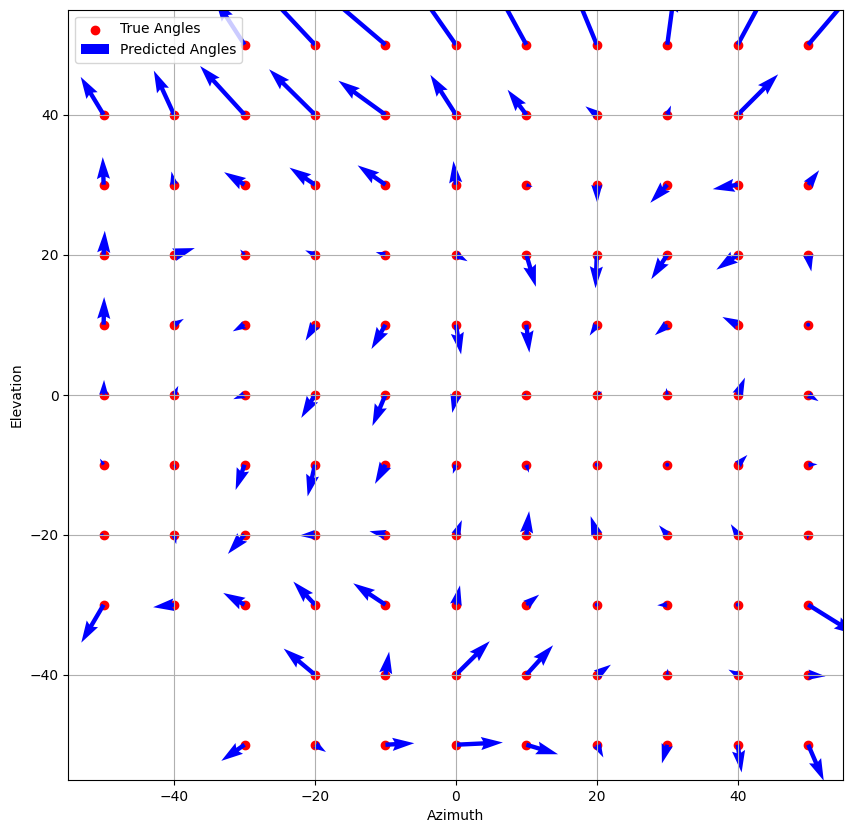

In [58]:
criterion = nn.L1Loss()
experiment_path = '/home/mohammad.hallaq/workarea/AoA-Pruning/experiments'
device = general_device
original_model = original_model.to(device)
original_model.eval()
pruned_model = pruned_model.to(device)
pruned_model.eval()
eval_values = {'azimuth_true': [], 'azimuth_pred': [], 'elevation_true': [], 'elevation_pred': [], 'loss_value': []}

test_loss, test_loss_pruned, num_samples = 0, 0, 0
all_targets, all_outputs, all_outputs_pruned = np.zeros([1, 2]), np.zeros([1, 2]), np.zeros([1, 2])
with torch.no_grad():
    with tqdm(test_loader, desc='Testing', unit='batch') as pbar:
        for sample_inputs, targets in pbar:
            sample_inputs = sample_inputs.to(device)
            targets = targets.to(device)
            outputs_pruned = pruned_model(sample_inputs)
            outputs = original_model(sample_inputs)
            loss_pruned = criterion(outputs_pruned, targets)
            loss = criterion(outputs, targets)
            eval_values['azimuth_pred'] = targets
            num_samples += targets.shape[0]
            test_loss_pruned += loss_pruned.item()/num_samples
            test_loss += loss.item()/num_samples
            all_targets = np.concatenate((all_targets, targets.cpu()))
            all_outputs = np.concatenate((all_outputs, outputs.cpu()))
            all_outputs_pruned = np.concatenate((all_outputs_pruned, outputs_pruned.cpu()))
            pbar.set_postfix({'Val Loss': test_loss_pruned})
            pbar.set_postfix({'Val Loss': test_loss})
    all_outputs = all_outputs[1:]
    all_outputs_pruned = all_outputs_pruned[1:]
    all_targets = all_targets[1:]
    test_loss = test_loss / len(test_loader)
    print(f"Test Set Loss = {test_loss}")
    test_loss_pruned = test_loss_pruned / len(test_loader)
    print(f"Test Set Loss for pruned model = {test_loss_pruned}")
    quiver_path = os.path.join(experiment_path, "testing_quiver_plot.png")
    plot_quiver(all_targets, all_outputs, quiver_path)
    plot_quiver(all_targets, all_outputs_pruned, quiver_path)

In [26]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

# Define both MSE and MAE criteria
mse_criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()

device = general_device
pruned_model = pruned_model.to(device)
pruned_model.eval()

# Initialize dictionaries to accumulate MSE and MAE losses for each angle
angle_loss_accumulation = {
    'azimuth_mse': {angle: 0.0 for angle in range(-50, 60, 10)},
    'elevation_mse': {angle: 0.0 for angle in range(-50, 60, 10)},
    'azimuth_mae': {angle: 0.0 for angle in range(-50, 60, 10)},
    'elevation_mae': {angle: 0.0 for angle in range(-50, 60, 10)},
    'azimuth_count': {angle: 0 for angle in range(-50, 60, 10)},
    'elevation_count': {angle: 0 for angle in range(-50, 60, 10)}
}

test_mse, test_mae, num_samples = 0, 0, 0
all_targets, all_outputs = np.zeros([1, 2]), np.zeros([1, 2])

with torch.no_grad():
    with tqdm(test_loader, desc='Testing', unit='batch') as pbar:
        for sample_inputs, targets in pbar:
            sample_inputs = sample_inputs.to(device)
            targets = targets.to(device)
            outputs = pruned_model(sample_inputs)
            
            # Calculate losses for this batch
            mse_loss = mse_criterion(outputs, targets)
            mae_loss = mae_criterion(outputs, targets)
            num_samples += targets.shape[0]

            test_mse += mse_loss.item() / num_samples
            test_mae += mae_loss.item() / num_samples

            # Convert to CPU and detach for evaluation
            outputs_np = outputs.cpu().numpy()
            targets_np = targets.cpu().numpy()

            # Accumulate MSE and MAE losses for each angle
            for i in range(targets_np.shape[0]):
                true_azimuth, true_elevation = targets_np[i]
                pred_azimuth, pred_elevation = outputs_np[i]

                azimuth_mse = (pred_azimuth - true_azimuth) ** 2
                elevation_mse = (pred_elevation - true_elevation) ** 2

                azimuth_mae = abs(pred_azimuth - true_azimuth)
                elevation_mae = abs(pred_elevation - true_elevation)

                # Accumulate losses for each azimuth and elevation value
                angle_loss_accumulation['azimuth_mse'][int(true_azimuth)] += azimuth_mse
                angle_loss_accumulation['elevation_mse'][int(true_elevation)] += elevation_mse
                angle_loss_accumulation['azimuth_mae'][int(true_azimuth)] += azimuth_mae
                angle_loss_accumulation['elevation_mae'][int(true_elevation)] += elevation_mae

                # Count occurrences of each azimuth and elevation value
                angle_loss_accumulation['azimuth_count'][int(true_azimuth)] += 1
                angle_loss_accumulation['elevation_count'][int(true_elevation)] += 1

            all_targets = np.concatenate((all_targets, targets_np))
            all_outputs = np.concatenate((all_outputs, outputs_np))

            pbar.set_postfix({'Val MSE Loss': test_mse, 'Val MAE Loss': test_mae})

    all_outputs = all_outputs[1:]
    all_targets = all_targets[1:]
    test_mse = test_mse / len(test_loader)
    test_mae = test_mae / len(test_loader)

    # Calculate average MSE and MAE loss per angle
    avg_azimuth_mse, avg_elevation_mse = {}, {}
    avg_azimuth_mae, avg_elevation_mae = {}, {}

    for angle in range(-50, 60, 10):
        if angle_loss_accumulation['azimuth_count'][angle] > 0:
            avg_azimuth_mse[angle] = angle_loss_accumulation['azimuth_mse'][angle] / angle_loss_accumulation['azimuth_count'][angle]
            avg_azimuth_mae[angle] = angle_loss_accumulation['azimuth_mae'][angle] / angle_loss_accumulation['azimuth_count'][angle]
        else:
            avg_azimuth_mse[angle] = 0.0
            avg_azimuth_mae[angle] = 0.0

        if angle_loss_accumulation['elevation_count'][angle] > 0:
            avg_elevation_mse[angle] = angle_loss_accumulation['elevation_mse'][angle] / angle_loss_accumulation['elevation_count'][angle]
            avg_elevation_mae[angle] = angle_loss_accumulation['elevation_mae'][angle] / angle_loss_accumulation['elevation_count'][angle]
        else:
            avg_elevation_mse[angle] = 0.0
            avg_elevation_mae[angle] = 0.0
    
        print(f"For azimuth angle of {angle} degrees, we have {angle_loss_accumulation['azimuth_count'][angle]} samples")
        print(f"For elevation angle of {angle} degrees, we have {angle_loss_accumulation['elevation_count'][angle]} samples")

    print(f"Test Set MSE Loss = {test_mse}")
    print(f"Test Set MAE Loss = {test_mae}")
    print(f"Azimuth MSE Loss by Angle: {avg_azimuth_mse}")
    print(f"Elevation MSE Loss by Angle: {avg_elevation_mse}")
    print(f"Azimuth MAE Loss by Angle: {avg_azimuth_mae}")
    print(f"Elevation MAE Loss by Angle: {avg_elevation_mae}")

Testing: 100%|██████████| 360/360 [00:08<00:00, 43.87batch/s, Val MSE Loss=0.643, Val MAE Loss=0.136]

For azimuth angle of -50 degrees, we have 2750 samples
For elevation angle of -50 degrees, we have 3140 samples
For azimuth angle of -40 degrees, we have 3100 samples
For elevation angle of -40 degrees, we have 3440 samples
For azimuth angle of -30 degrees, we have 3790 samples
For elevation angle of -30 degrees, we have 4030 samples
For azimuth angle of -20 degrees, we have 4730 samples
For elevation angle of -20 degrees, we have 4650 samples
For azimuth angle of -10 degrees, we have 4730 samples
For elevation angle of -10 degrees, we have 4730 samples
For azimuth angle of 0 degrees, we have 4730 samples
For elevation angle of 0 degrees, we have 4730 samples
For azimuth angle of 10 degrees, we have 4730 samples
For elevation angle of 10 degrees, we have 4730 samples
For azimuth angle of 20 degrees, we have 4660 samples
For elevation angle of 20 degrees, we have 4730 samples
For azimuth angle of 30 degrees, we have 4510 samples
For elevation angle of 30 degrees, we have 4730 samples
Fo

In [59]:
def calculate_average_deviation(loader, model):
    device = next(model.parameters()).device
    model.to(device)
    total_azimuth_deviation = 0
    total_elevation_deviation = 0
    num_samples = 0
    with torch.no_grad():
        for batch in loader:
            inputs, true_angles = batch
            inputs, true_angles = inputs.to(device), true_angles.to(device)
            predicted = model(inputs).cpu().numpy()
            true_angles = true_angles.cpu().numpy()
            azimuth_deviation = np.abs(predicted[:, 0] - true_angles[:, 0])
            elevation_deviation = np.abs(predicted[:, 1] - true_angles[:, 1])
        
            total_azimuth_deviation += np.sum(azimuth_deviation)
            total_elevation_deviation += np.sum(elevation_deviation)
            num_samples += len(true_angles)
    avg_azimuth_deviation = total_azimuth_deviation / num_samples
    avg_elevation_deviation = total_elevation_deviation / num_samples
    return avg_azimuth_deviation, avg_elevation_deviation

avg_azim_dev, avg_elev_dev = calculate_average_deviation(test_loader, original_model)
avg_azim_dev_pruned, avg_elev_dev_pruned = calculate_average_deviation(test_loader, pruned_model)
print(f"Original Average Azimuth Deviation is {avg_azim_dev} / Original Average Elevation Deviation is {avg_elev_dev}")
print(f"Average Azimuth Deviation after Pruning is {avg_azim_dev_pruned} / Average Elevation Deviation after Pruning is {avg_elev_dev_pruned}")

Original Average Azimuth Deviation is 2.4212161223439352 / Original Average Elevation Deviation is 2.154647789316729
Average Azimuth Deviation after Pruning is 2.892772232526901 / Average Elevation Deviation after Pruning is 3.162521153566577


In [29]:
def measure_inference_time(model: torch.nn.Module, validation_loader: torch.utils.data.DataLoader, inference_device: str, num_tests: int = 20, num_iterations: int = 1000) -> None:
    """
    Measure the inference time of a PyTorch model on CPU for multiple tests and iterations.
    """

    torch.manual_seed(42)

    
    # Move the model to CPU and set it to evaluation mode
    device = inference_device
    model.to(device)
    model.eval()

    # Disable gradient calculations for inference
    overall_total_time = 0.0

    # Fetch a single batch outside the loop
    first_batch = next(iter(validation_loader))
    input_tensor, _ = first_batch
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        for test in range(num_tests):
            # print(f"Running Test {test + 1}/{num_tests}")
            test_total_time = 0.0

            for iteration in range(num_iterations):
                # Start timing
                start_time = time.time()
                
                # Perform inference
                _ = model(input_tensor)

                # End timing and record
                batch_inference_time = time.time() - start_time
                test_total_time += batch_inference_time

            # Calculate the average inference time per iteration for this test
            avg_test_time = test_total_time / num_iterations
            overall_total_time += test_total_time

            # print(f"Total inference time for Test {test + 1}: {test_total_time:.4f} seconds")
            # print(f"Average inference time per iteration for Test {test + 1}: {avg_test_time:.4f} seconds\n")

    # Calculate and print overall statistics
    overall_avg_time = overall_total_time / (num_tests * num_iterations)
    # print(f"Overall total inference time for {num_tests} tests: {overall_total_time:.4f} seconds")
    # print(f"Overall average inference time per iteration: {overall_avg_time:.4f} seconds")

    return overall_avg_time


In [30]:
pruned_model = torch.load('inference_cmparison/best_trained_model.pth', map_location='cpu')

avg_time = measure_inference_time(pruned_model, test_loader, 'cuda')

In [31]:
avg_time

0.0022492727994918825

In [21]:
avg_time

0.0017912350177764892

In [18]:
avg_time

0.013022107601165771

In [ ]:
# Measure the inference time on CPU
avg_time = measure_inference_time(uniform_pruned_model, test_loader)

In [12]:
def analyze_model_and_save_to_csv(model, val_loader, device=None, csv_file='model_analysis.csv', model_name=None):
  
    if device is None:
        device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
    
    print(device)
    
    # Set seed for reproducibility
    torch.manual_seed(42)

    first_batch = next(iter(val_loader))
    input_tensor, true_angles = first_batch
    input_tensor = input_tensor.to(device)


    model.to(device)
    example_inputs = input_tensor.to(device)
    print('This is the shape of the input: ', example_inputs.shape)
    

    analysis_results = {
        'model_name': model_name if model_name else model.__class__.__name__,
        'model_size_mb (MB)': None,
        'GFLOPs (GFLOPs)': None,
        'Total_Params (count)': None,
        'First_Forward_Pass_Time (s)': None,
        'Training_Time (s)': None,
        'Inference_Time (s)': None,
        'CUDA_Time (ms)': None,
        'CPU_Time (ms)': None,
        'mse': None,
        'mae': None
    }
    
 
    # try:
    #     model.to(device)
    #     example_inputs = example_inputs.to(device)
    
 
    #     flops, params = tp.utils.count_ops_and_params(model, example_inputs)
    #     analysis_results['GFLOPs (GFLOPs)'] = flops  
    #     analysis_results['Total_Params (count)'] = params

    # except Exception:
    #     pass 


    # try:
    #     torch.save(model.state_dict(), "temp.pth")
    #     model_size = os.path.getsize("temp.pth") / (1024 * 1024)  # Convert to MB
    #     os.remove("temp.pth")
    #     analysis_results['model_size_mb (MB)'] = model_size
    # except Exception:
    #     pass


    try:
        model.to(device)
        model.eval()
        example_inputs = example_inputs.to(device)

        with torch.no_grad():
            start_time = time.time()
            _ = model(example_inputs)
            end_time = time.time()
        analysis_results['First_Forward_Pass_Time (s)'] = end_time - start_time
    except Exception:
        pass

    try:
        # Create CUDA events to measure time
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        iterations = 1000 # Number of iterations within each test
        num_tests = 20 # Number of times to run the inference test
        total_time = 0.0
        
        for test in range(num_tests):
            # Record the start time
            start_event.record()
            for _ in range(iterations):
                with torch.no_grad():
                    _ = model(example_inputs)
            end_event.record()
            torch.cuda.synchronize()
            iteration_time = start_event.elapsed_time(end_event)/iterations
            total_time += iteration_time
        
        average_inference_time = total_time / num_tests
        
        analysis_results['Inference_Time (ms)'] = average_inference_time
    except Exception:
        pass


    # try:
    #     model.eval()
    #     with torch.no_grad():
    #         if torch.cuda.is_available():
    #             torch.cuda.synchronize()  
    #             with profile(use_cuda=True) as prof:
    #                 _ = model(example_inputs)
    #             # Collect CUDA times
    #             cuda_time_total = sum(evt.cuda_time for evt in prof.key_averages())
    #             cpu_time_total = sum(evt.cpu_time_total for evt in prof.key_averages())
    #             analysis_results['CUDA_Time (ms)'] = cuda_time_total / 1e3
    #             analysis_results['CPU_Time (ms)'] = cpu_time_total / 1e3
    #         else:
    #             with profile(use_cuda=False) as prof:
    #                 _ = model(example_inputs)
    #             # Collect CPU times only
    #             cpu_time_total = sum(evt.cpu_time_total for evt in prof.key_averages())
    #             analysis_results['CPU_Time (ms)'] = cpu_time_total / 1e3
    # except Exception as e:
    #     print(f"Error during profiling: {e}")
    #     pass

    # try:
    #     model.eval()
    #     y_preds = []
    #     y_true = []
    #     with torch.inference_mode():
    #         for sample in val_loader:
    #             data, target = sample[0].to(device), sample[1].to(device)
    #             y_true += target.tolist()
    #             output = model(data)
    #             y_preds += output.cpu().tolist()

    #     y_true = np.array(y_true)
    #     y_preds = np.array(y_preds)


    #     mse = np.square(y_true - y_preds).mean()
    #     mae = np.absolute(y_true - y_preds).mean()

    #     analysis_results['mse'] = mse
    #     analysis_results['mae'] = mae
    # except Exception:
    #     pass
    

    # file_exists = os.path.isfile(csv_file)
    
    # with open(csv_file, mode='a', newline='') as f:
    #     writer = csv.DictWriter(f, fieldnames=analysis_results.keys())
        
    #     if not file_exists:
    #         writer.writeheader()  
        
    #     writer.writerow(analysis_results)  

    return analysis_results

In [ ]:
# Free up cached memory
torch.cuda.empty_cache()

# Clear all the gradients
torch.cuda.reset_max_memory_allocated()

# example_inputs = torch.randn(128, 1, 8, 4096)  
pruned_results = analyze_model_and_save_to_csv(pruned_model, test_loader, device=general_device, csv_file='model_analysis.csv')

In [13]:
pruned_results

{'model_name': 'MobileNetV3',
 'model_size_mb (MB)': None,
 'GFLOPs (GFLOPs)': None,
 'Total_Params (count)': None,
 'First_Forward_Pass_Time (s)': 0.0650014877319336,
 'Training_Time (s)': None,
 'Inference_Time (s)': None,
 'CUDA_Time (ms)': None,
 'CPU_Time (ms)': None,
 'mse': None,
 'mae': None,
 'Inference_Time (ms)': 33.25864414062501}

In [11]:
pruned_model = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/Best_latest_models/15k_pruned_model.pth', map_location=general_device)

In [13]:
# Free up cached memory
torch.cuda.empty_cache()

# Clear all the gradients
torch.cuda.reset_max_memory_allocated()

# example_inputs = torch.randn(128, 1, 8, 4096)  
results = analyze_model_and_save_to_csv(pruned_model, test_loader, device=general_device, csv_file='model_analysis_new.csv')

cuda:2
This is the shape of the input:  torch.Size([128, 8, 4096])


In [14]:
results

{'model_name': 'MobileNetV3',
 'model_size_mb (MB)': None,
 'GFLOPs (GFLOPs)': None,
 'Total_Params (count)': None,
 'First_Forward_Pass_Time (s)': 0.3908727169036865,
 'Training_Time (s)': None,
 'Inference_Time (s)': None,
 'CUDA_Time (ms)': None,
 'CPU_Time (ms)': None,
 'mse': None,
 'mae': None,
 'Inference_Time (ms)': 6.696503027343749}